In [1]:
# -*- coding: utf-8 -*-
#  File: otus_adv_hw1_automl_atom.ipynb
#  Project: 'OTUS.ADV Homework #1'
#  Created by Gennady Matveev (gm@og.ly) on 06-01-2022.

# **$Homework$** **$3$**  
**OTUS Machine Learning Advanced**

### Time series clustering

![AutoML](https://docs.google.com/uc?export=download&id=1kP52pViswEsaHNrJUuCUxwXng4oBY3Cu)
<!-- https://drive.google.com/file/d/1kP52pViswEsaHNrJUuCUxwXng4oBY3Cu/view?usp=sharing -->

Apply clustering algorithms to multiple time series (TS):
- A list of cryptocurrencies (CC), including Bitcoin (~100)
    - 30 days of closing prices
    - 3 days hourly closing prices
    - 1 hour minute closing prices
- Compare KNN (or similar) and DTW approaches;
- Try TS clustering after automatic feature generation with TSFEL;
- Analyze composition of clusters without Bitcoin.

**Additional goals:**  

- Build risk profile for CC portfolios from one cluster and from
different clusters;
- Apply Matrix Profile methods from [matrixprofile](https://github.com/matrix-profile-foundation/matrixprofile) library to find repeated motifs and discords (anomalies) on CC from various clusters.


**Means:**  

- All meaningful computations will be done in [tslearn](https://github.com/tslearn-team/tslearn/).  

**Data:**  

- CC prices will be downloaded with [cryptocompare](https://github.com/lagerfeuer/cryptocompare) library.

**Choice of models:**  



**Methodology:**  


Goals:   

Apply clustering algorithms to multiple time series (TS):
- A list of cryptocurrencies (CC), including Bitcoin (~100)
    - 30 days of closing prices
    - 3 days hourly closing prices
    - 1 hour minute closing prices
- Compare KNN (or similar) and DTW approaches;
- Analyze composition of clusters without Bitcoin.

Means:  
- All preprocessing and pipelines management will be done in [ATOM](https://tvdboom.github.io/ATOM/).

Data:
- CC prices will be downloaded with [cryptocompare](https://github.com/lagerfeuer/cryptocompare) library.

Abbreviations:
- TS: time series
- CC: cryptocurrency
- DTW: dynamic time warping
- FE: feature engineering
- H/P: hyperparameters

<a href="https://colab.research.google.com/github/oort77/OTUS_ADV_HW3/blob/main/notebooks/otus_adv_hw3_dtw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Google colab specific part

<!-- Typical runtime on Colab is several hours unless you set **max_time_mins** of atom.automl in **_Create AutoML model with DFS_** section to lower value.  

Note that this notebook runs on 20% of data by default. This can be changed in **_Take part of data_** section: either change rand_part value to set a desired percentage of data to use or set partial = 0 to run on full data.

Please uncomment below to install the notebook dependencies.

Dependencies installation requires restart of runtime. -->

In [2]:
# !pip install -r 'https://drive.google.com/uc?export=download&id=1VmHDlGXo1IMHZ2kAT5IW4r4suWAfmiXs'

### Import libraries and setup notebook

In [3]:
import os
import pandas as pd
import numpy as np
from atom import ATOMClassifier #, ATOMLoader
from sklearn.preprocessing import StandardScaler, \
                    RobustScaler, MinMaxScaler

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import cryptocompare as cc

import matplotlib.pyplot as plt
import seaborn as sns

import re
import gdown
import random
import shutil
import pickle
import warnings
import requests
from kneed import KneeLocator
from tqdm.autonotebook import tqdm
from IPython.core.display import display, HTML

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/


#### Miscellaneius settings 

In [4]:
%matplotlib inline
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize']=(10,5)
sns.set(rc = {'figure.figsize':(8,5)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4

#### ML parameters

In [5]:
random_state = 17
n_jobs = -1 # Try 2 on Colab
scaler = StandardScaler()

### Load data

#### Set up cryptocompare API

In [6]:
cc.cryptocompare._set_api_key_parameter("5db769e8ae211fc8c106e10623db6384dc64db9c26b2a2df708f8d1b53f99f92")

'&api_key=5db769e8ae211fc8c106e10623db6384dc64db9c26b2a2df708f8d1b53f99f92'

#### Utility functions for cryptocompare downloads

In [7]:
def get_price(ticker: str, time_interval: str, limit: int):
    if time_interval == "day":
        result = cc.get_historical_price_day(ticker, currency="USD", 
                                             limit=limit) # exchange="Kraken",
    elif time_interval == "hour":
        result = cc.get_historical_price_hour(ticker, currency="USD", 
                                              limit=limit)
    elif time_interval == "minute":
        result = cc.get_historical_price_minute(ticker, currency="USD", 
                                                limit=limit)
    else:
        print("Please check your time_interval input")
    return result

In [8]:
def get_all_cc(time_interval: str, limit: int):
    df = pd.DataFrame(index=range(limit))
    for tick in tickers:
        print(tick, end="\t")
        try:
            d = get_price(tick,time_interval, limit)
            one_cc = pd.DataFrame.from_dict(d)["close"]
            one_cc.rename(index=tick, inplace=True)
            df = pd.concat([df, one_cc], axis=1)#,ignore_index=True)
            print("OK")
        except:
            print(f"{tick} passed")
#     df.columns = tickers
    return df

#### Download data, top-100 CC by market cap

In [9]:
# Download data from Google Drive
if os.path.isdir("../data") == False:
    !mkdir ../data

url_arch = "https://drive.google.com/uc?export=download&id=1XCOhxPfRDp6SxMyPwPO1nse3MI2vOFvP"
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36' }

    # Download, if necessary
if not os.path.exists("../data/Archive.zip"):
    # Check if data archive is still in Google Drive
    if requests.head(url_arch, headers=headers).status_code in [200, 302]:
        gdown.download(url_arch, output="../data/Archive.zip")
        shutil.unpack_archive("../data/Archive.zip", "../data")
    # If not, get data from cryptocompare.com
    else:
        data_day = get_all_cc("day", 30)
        data_hour = get_all_cc("hour", 72)
        data_minute = get_all_cc("minute", 60)
# Extract data from existing pickles
else:
    with open("../data/data_day.pickle","rb") as f:
        data_day = pickle.load(f)
    with open("../data/data_hour.pickle","rb") as f:
        data_hour = pickle.load(f)
    with open("../data/data_minute.pickle","rb") as f:
        data_minute = pickle.load(f)

In [10]:
# Check CC list dataframe   
if not os.path.exists("../data/cryptocurrencies.pickle"):
    cc_url = "https://drive.google.com/uc?export=download&id=1Q09m-PfvhiBZ75lwXaHtafsajmXPW3WD"
    gdown.download(cc_url, output="../data/cryptocurrencies.pickle")
with open("../data/cryptocurrencies.pickle", "rb") as f:
    ccs = pickle.load(f)
tickers = ccs["ticker"].to_list()

#### Save data to pickles

In [11]:
# with open("../data/data_minute.pickle","wb") as f:
#             pickle.dump(data_minute, f)
# with open("../data/data_hour.pickle","wb") as f:
#             pickle.dump(data_hour, f)
# with open("../data/data_day.pickle","wb") as f:
#             pickle.dump(data_day, f)

### CC data - visual check

In [12]:
data_day.head()

BTC      ETH     XRP   USDT     BNB     SOL    USDC   LUNA    ADA  \
0  42743.03  3240.32  0.7703  1.001  463.38  140.25  1.0000  73.51  1.188   
1  43919.67  3373.03  0.7989  1.000  487.51  151.51  1.0000  81.91  1.312   
2  42575.61  3242.26  0.7678  1.000  475.57  146.20  1.0000  78.36  1.233   
3  43089.83  3309.66  0.7734  1.001  490.36  146.18  1.0000  81.45  1.293   
4  43088.74  3328.63  0.7796  1.000  494.66  147.74  0.9996  87.30  1.292   

    AVAX  ...  FXS      HT     CHZ    ENJ   JASMY    ENS    XCH    DFI  \
0  89.64  ...  0.0   9.403  0.2641  2.317  0.0708  26.75  88.52  2.618   
1  96.02  ...  0.0   9.509  0.2775  2.521  0.0730  27.99  95.48  2.994   
2  89.76  ...  0.0   9.511  0.2637  2.374  0.0695  25.69  92.94  2.971   
3  90.40  ...  0.0   9.855  0.2668  2.411  0.0707  26.28  91.61  3.001   
4  93.08  ...  0.0  10.020  0.2669  2.452  0.0703  26.68  92.12  3.102   

      BSV    ANC  
0  110.19  2.592  
1  112.83  2.704  
2  109.33  2.600  
3  113.02  2.503  
4  112.63  2.506  

[5 rows x 95 columns]

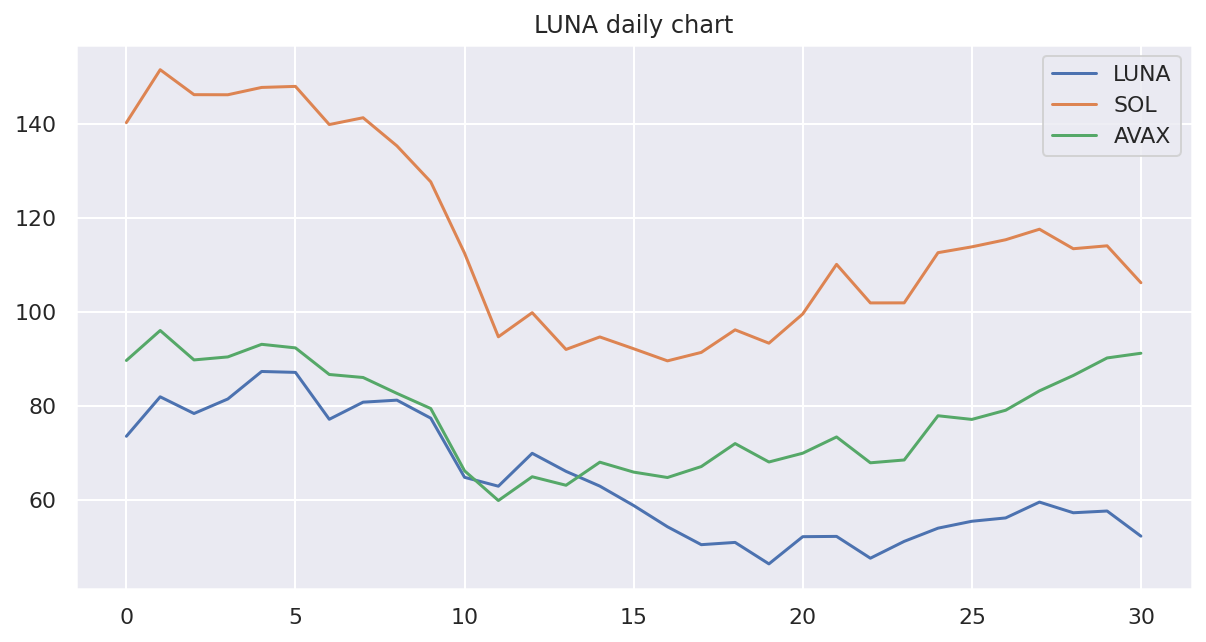

In [13]:
_ = data_day[["LUNA","SOL","AVAX"]].plot(title="LUNA daily chart", figsize=(10,5))

In [14]:
data_hour.head()

BTC      ETH     XRP   USDT     BNB     SOL    USDC   LUNA    ADA  \
0  44093.55  3153.03  0.8012  1.001  435.07  117.99  1.0000  59.26  1.188   
1  44104.37  3154.29  0.8265  1.001  434.96  118.10  0.9999  60.39  1.204   
2  43861.07  3141.38  0.8318  1.001  433.75  117.57  1.0000  59.51  1.199   
3  43886.13  3132.57  0.8260  1.001  433.08  117.11  1.0000  58.84  1.237   
4  44081.16  3154.16  0.8684  1.001  435.15  118.78  1.0000  59.67  1.251   

    AVAX  ...    FXS     HT     CHZ    ENJ   JASMY    ENS    XCH    DFI  \
0  83.51  ...  21.16  10.11  0.2338  2.121  0.0418  21.56  79.99  3.308   
1  83.64  ...  21.51  10.16  0.2347  2.127  0.0417  21.92  80.23  3.326   
2  83.18  ...  21.16  10.09  0.2337  2.090  0.0411  21.81  80.49  3.338   
3  82.59  ...  21.24  10.02  0.2326  2.085  0.0412  21.81  80.05  3.357   
4  83.36  ...  21.47  10.02  0.2355  2.127  0.0416  22.75  80.62  3.411   

      BSV    ANC  
0  102.68  1.578  
1  103.03  1.592  
2  102.15  1.604  
3  103.04  1.603  
4  104.23  1.627  

[5 rows x 95 columns]

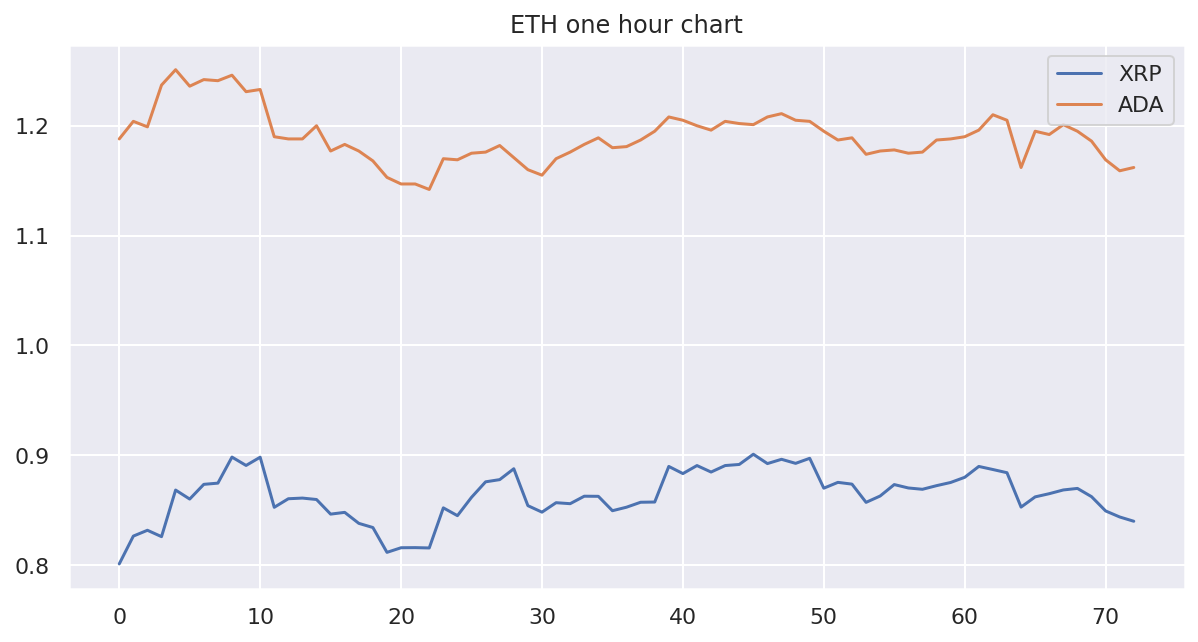

In [15]:
_ = data_hour[["XRP","ADA"]].plot(title="ETH one hour chart", figsize=(10,5))

In [16]:
data_minute.head()

BTC      ETH     XRP   USDT     BNB     SOL    USDC   LUNA    ADA  \
0  44571.95  3132.77  0.8549  1.001  422.01  109.21  1.0000  53.99  1.172   
1  44618.14  3136.05  0.8554  1.001  422.12  109.35  1.0000  54.03  1.173   
2  44580.50  3133.94  0.8546  1.001  421.80  109.16  0.9999  53.90  1.172   
3  44559.75  3135.46  0.8547  1.001  421.87  109.14  1.0000  53.78  1.171   
4  44568.13  3137.96  0.8540  1.001  421.83  109.28  1.0010  53.89  1.172   

    AVAX  ...    FXS     HT     CHZ    ENJ   JASMY    ENS    XCH    DFI  \
0  91.91  ...  21.08  10.02  0.2314  2.032  0.0401  19.35  82.77  3.671   
1  91.98  ...  21.10  10.03  0.2315  2.033  0.0401  19.37  82.86  3.675   
2  91.70  ...  20.96  10.01  0.2315  2.033  0.0399  19.34  82.61  3.672   
3  91.76  ...  21.08  10.00  0.2310  2.032  0.0401  19.34  82.66  3.670   
4  91.93  ...  20.95  10.03  0.2312  2.038  0.0399  19.31  82.67  3.665   

     BSV    ANC  
0  99.84  1.811  
1  99.94  1.814  
2  99.86  1.815  
3  99.72  1.812  
4  99.74  1.815  

[5 rows x 95 columns]

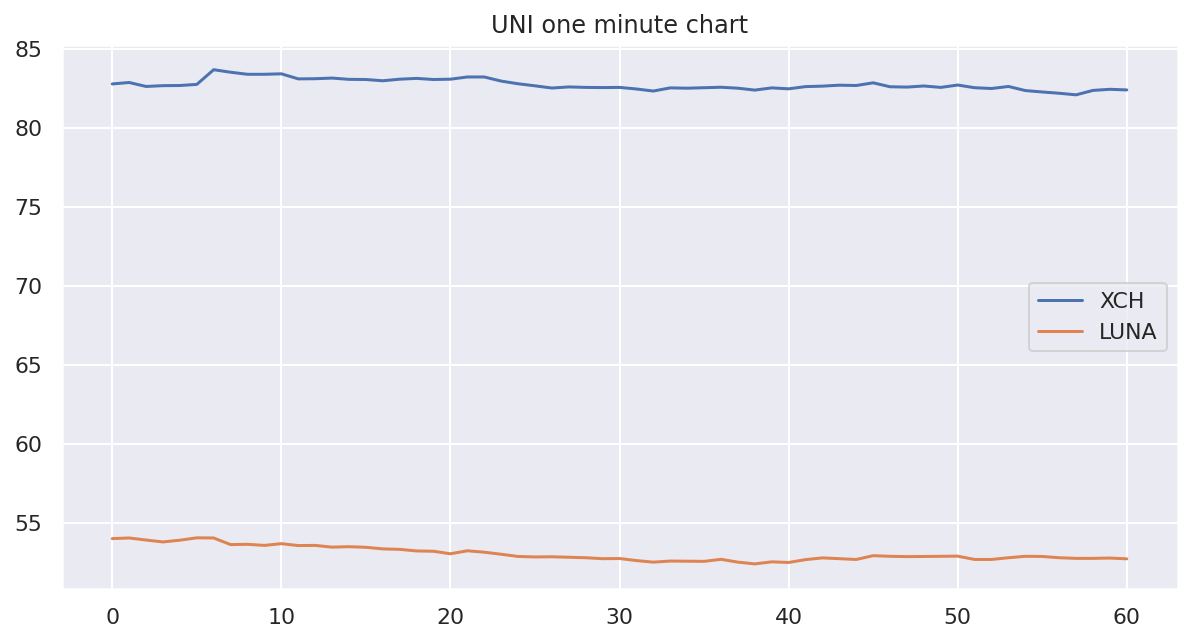

In [17]:
_ = data_minute[["XCH","LUNA"]].plot(title="UNI one minute chart", figsize=(10,5))

####  Utility functions for clustering study

In [18]:
def plot_all_cc(data, title):
    X = scaler.fit_transform(data)
    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(X)
    plt.suptitle(f"All CC scaled - {title}")
    plt.show()

In [19]:
def elbow_study(data, k_max: int = 10, metric: str = "euclidean", model=TimeSeriesKMeans):
    X = scaler.fit_transform(data)
    inertia = []
    silhouette = []
    for k in tqdm(range(2, k_max)):
        clusterer = model(n_clusters=k, metric=metric, 
                          n_jobs=n_jobs, max_iter=10, 
                          n_init=10, random_state=random_state)
        X_km = clusterer.fit(X)
        inertia.append(np.sqrt(X_km.inertia_))
        silhouette.append(silhouette_score(X, clusterer.labels_, 
                                           metric=metric, 
                                           random_state=random_state))

    fig, ax1 = plt.subplots(figsize=(14,5))
    ax2 = ax1.twinx()    
    ax1.plot(range(2, k_max), inertia, marker="s")
    ax1.set_title(f"The Elbow Method using Inertia\nmetric: {metric}")
    ax1.set_xlabel("Number of clusters")
    ax1.set_ylabel("Inertia")
    ax2.plot(range(2, k_max), silhouette, 'r-')
    ax2.set_ylabel('Silhouette', color='r')
    plt.show()
    
    # Find a knee
    kneedle = KneeLocator(range(2, k_max), inertia, S=2, 
                          curve="convex", direction="decreasing")
    # Use 3 clusters in case kneed doesn't find a knee
    n_clusters = kneedle.knee or 3 
    print(f"Optimal number of clusters - {kneedle.knee}")

    return n_clusters

In [20]:
def plot_centroids(data, n_clusters, title, metric="euclidean"):
    X = scaler.fit_transform(data_day)
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, 
                                 metric=metric, n_jobs=n_jobs, max_iter=100)
    ts_kmeans.fit(X.T)
    fig, _ = plt.subplots(figsize=(15,5))
    for cluster_number in range(n_clusters):
        plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, 
                 label=cluster_number)
    plt.title(f"Cluster centroids\n{title}")
    plt.legend()
    plt.show()

In [21]:
def print_clusters(data, n_clusters, title, metric="euclidean"):
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, 
                                 n_jobs=n_jobs, max_iter=100)
    X = scaler.fit_transform(data)
    data.loc["cluster"]=ts_kmeans.fit_predict(X.T)
#     clusters_no = data.loc["cluster"].nunique()
    color = ["g", "r", "b", "purple", "darkorange","lightblue","lightgreen"]
    for c in range(n_clusters):
        cc = color[c]
        fig, ax = plt.subplots(2,4,sharex='col',figsize=(15,5))
        cluster_ticks = data.T[data.T.loc[:,"cluster"]==c].index
        for i, tick in enumerate(cluster_ticks[:8]):
            ax[i%2,i//2].plot(data.iloc[:-1][tick], color=cc)#, label=tick)
            ax[i%2,i//2].set_title(tick)
        fig.suptitle(f"Cluster {c}\n" + title, y=1.02)
        fig.show()

In [22]:
def clustering_study(data, metric, title):
    # Plot all scaled CC
    plot_all_cc(data, title)
    # Run elbow study
    n_clusters = elbow_study(data, metric=metric)
    # Plot centroids
    plot_centroids(data, n_clusters, title, metric=metric)
    # Plot CC in clusters
    print_clusters(data, n_clusters, title, metric=metric)
    

### Run clustering study

#### Daily charts

##### KNeighbours, euclidean metric

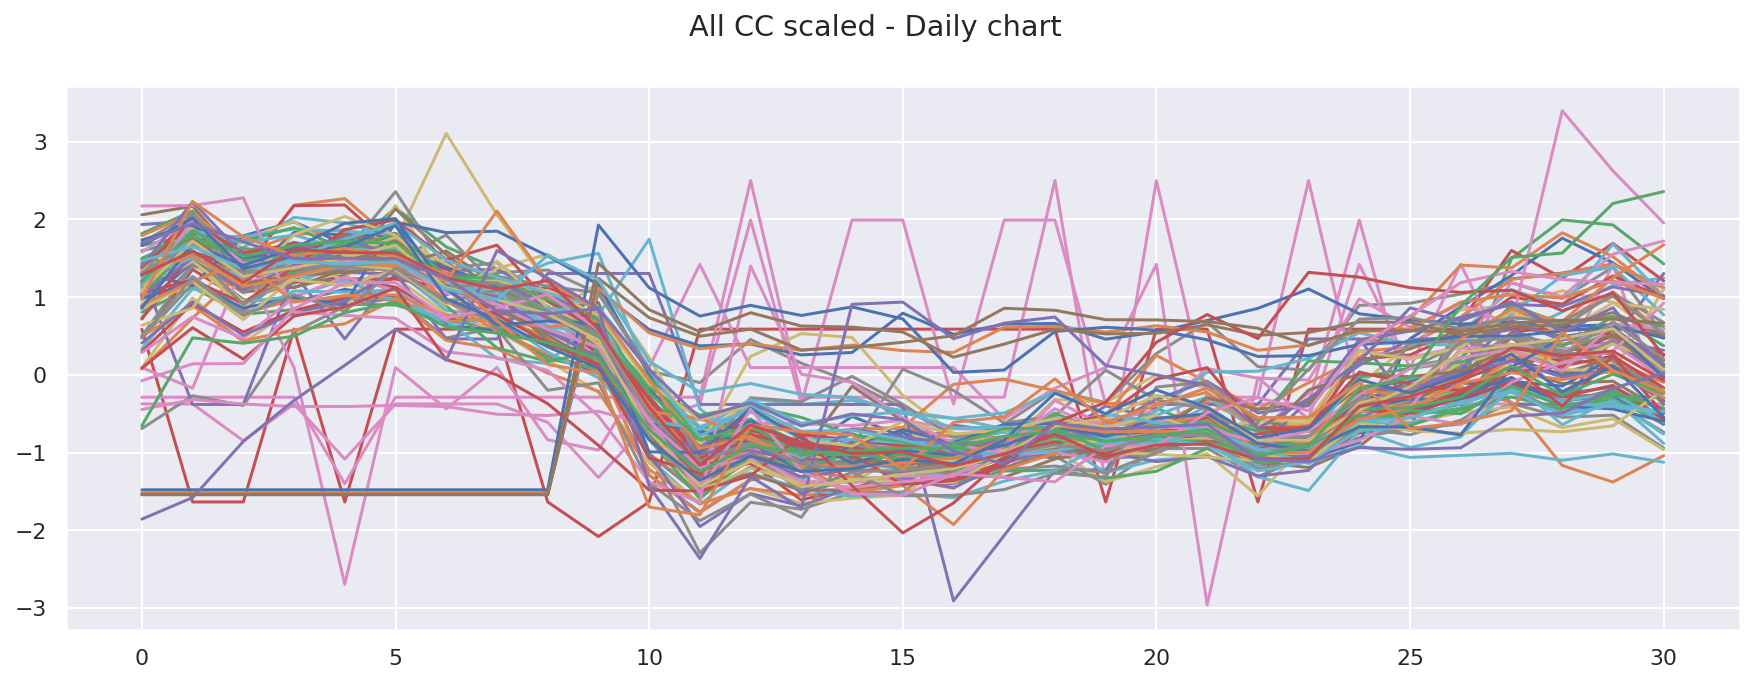

  0%|          | 0/8 [00:00<?, ?it/s]

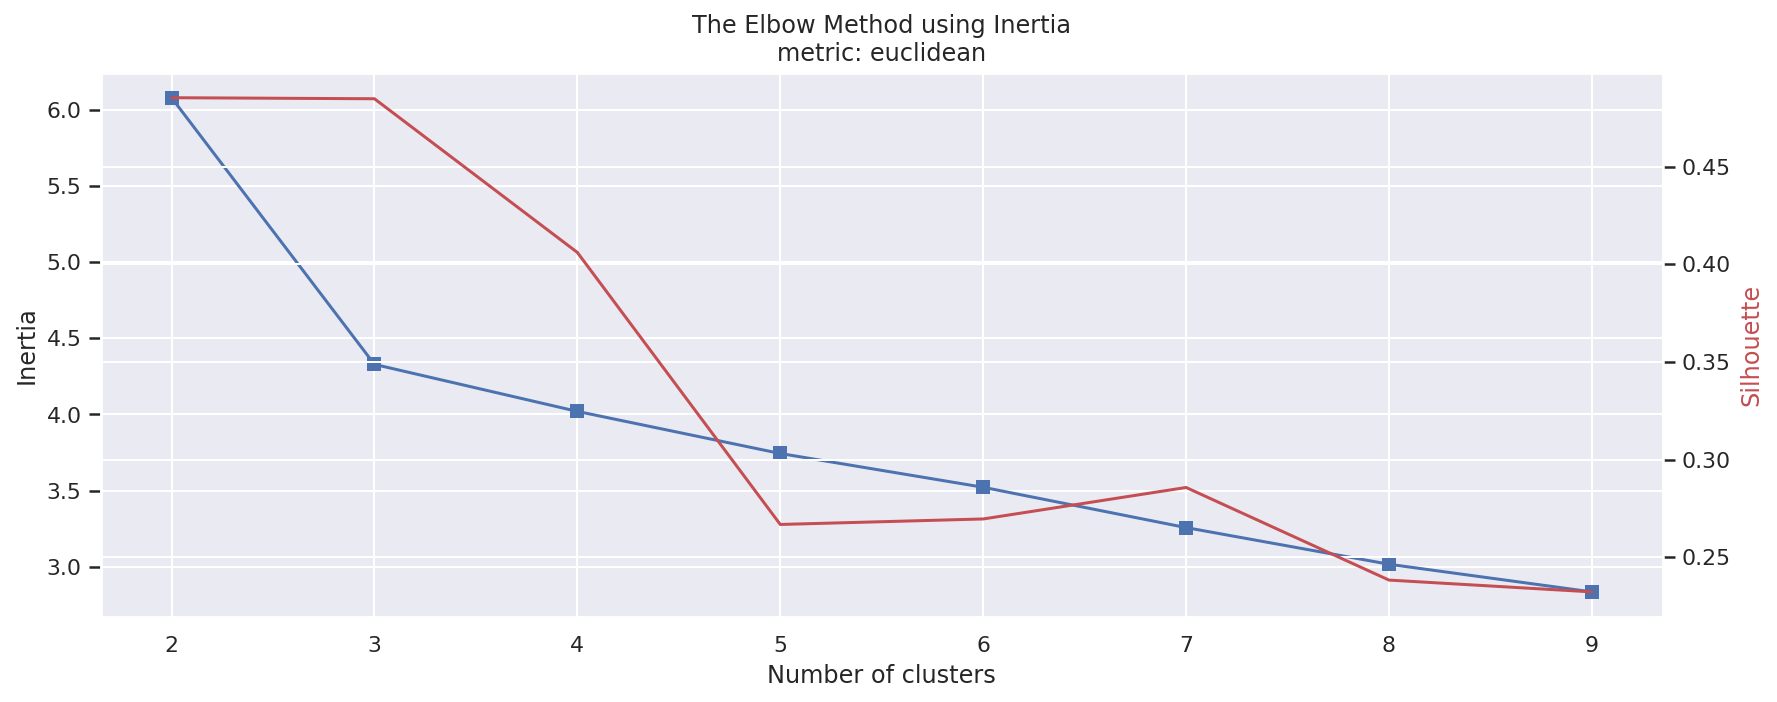

Optimal number of clusters - 3


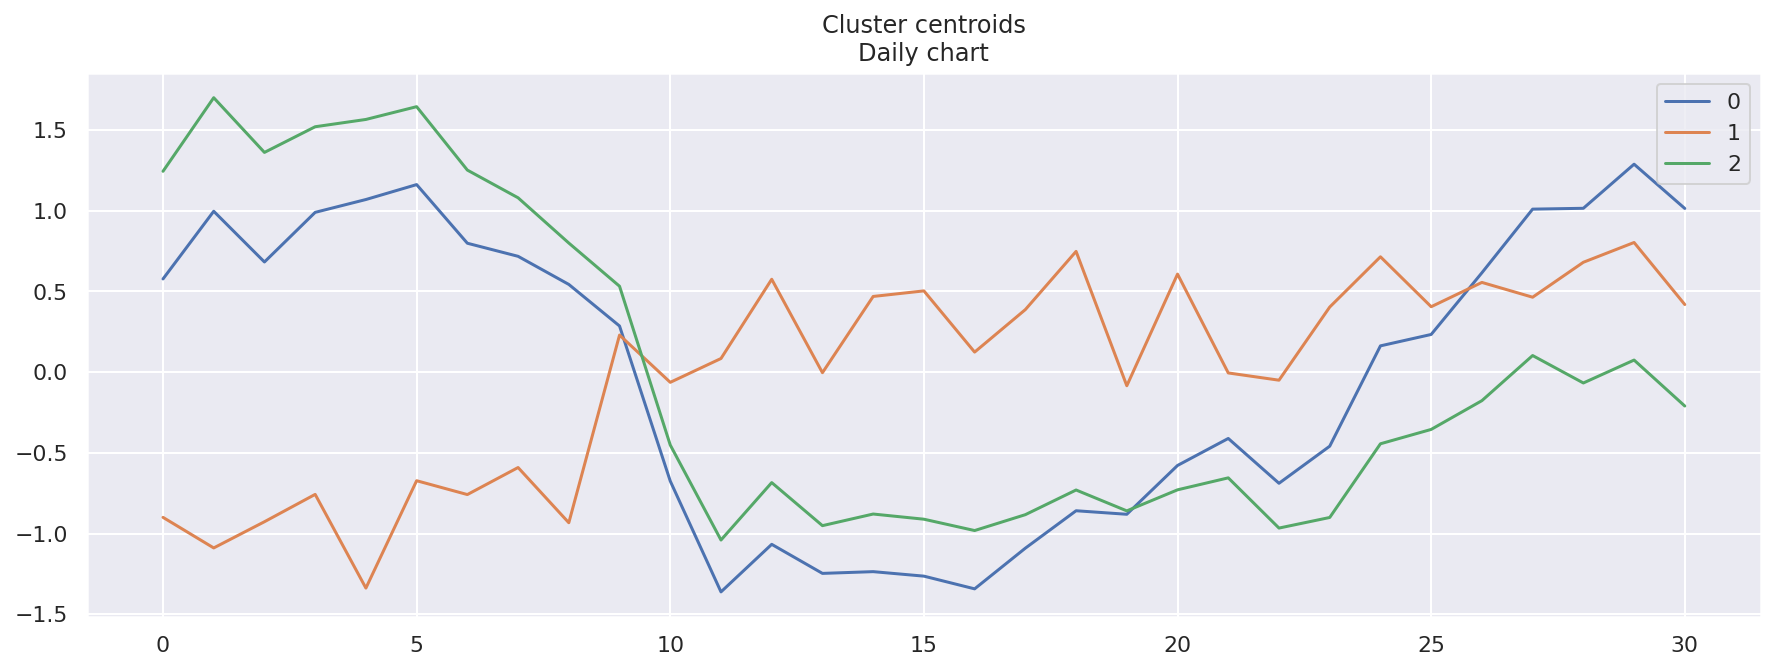

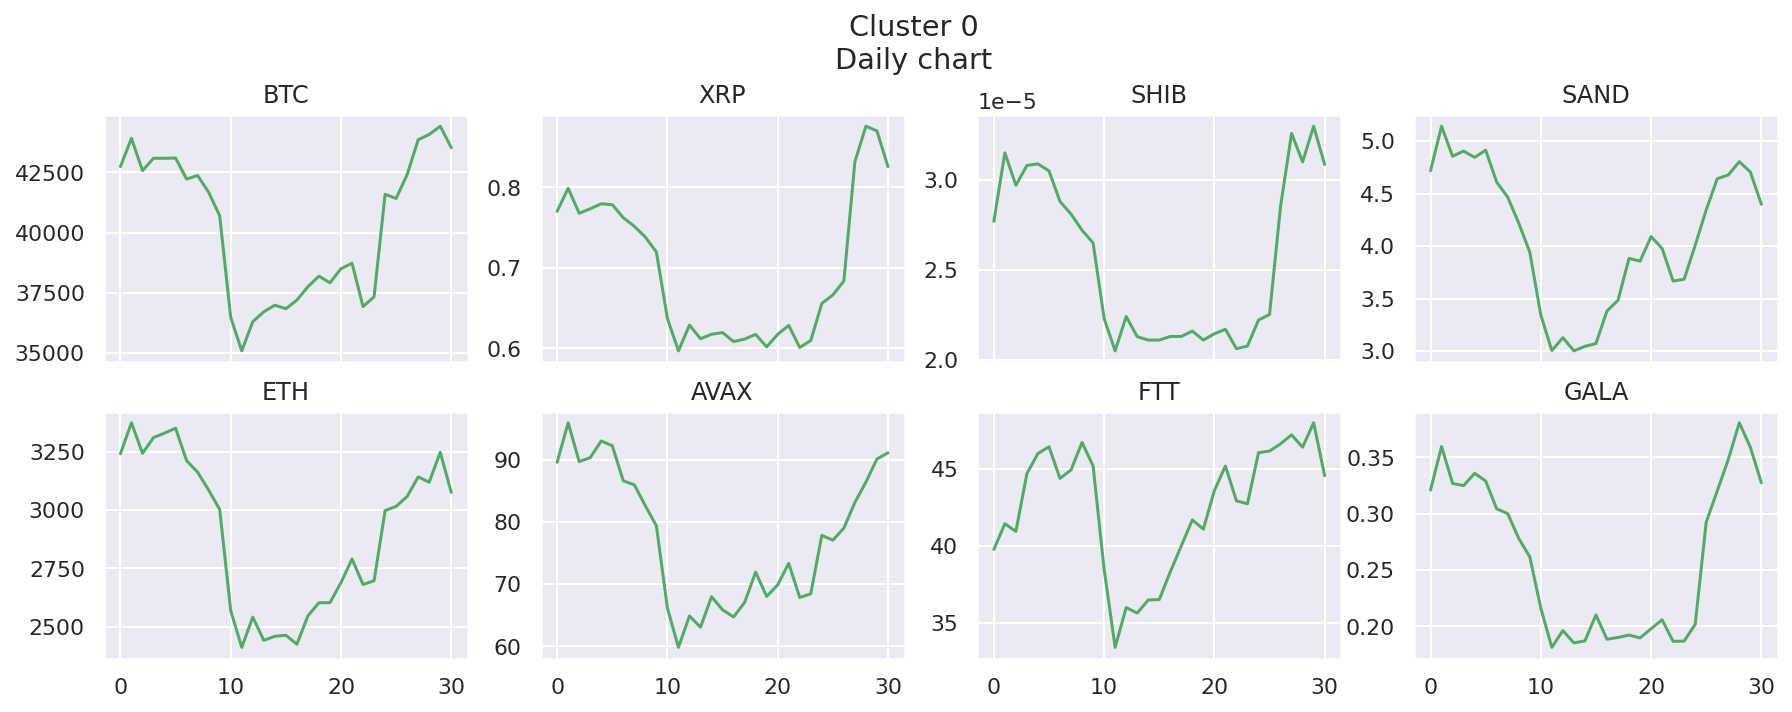

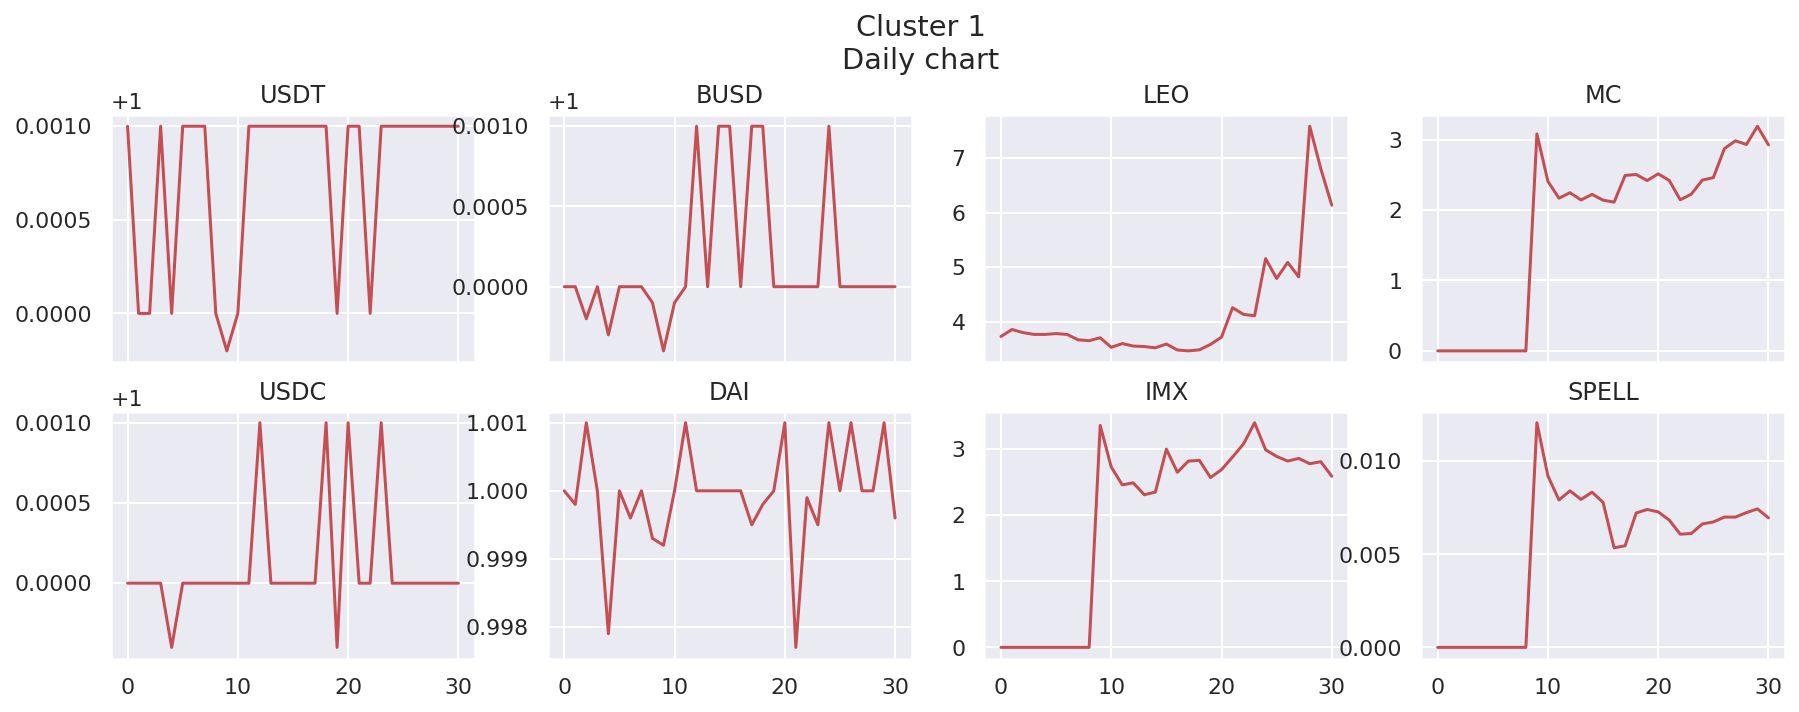

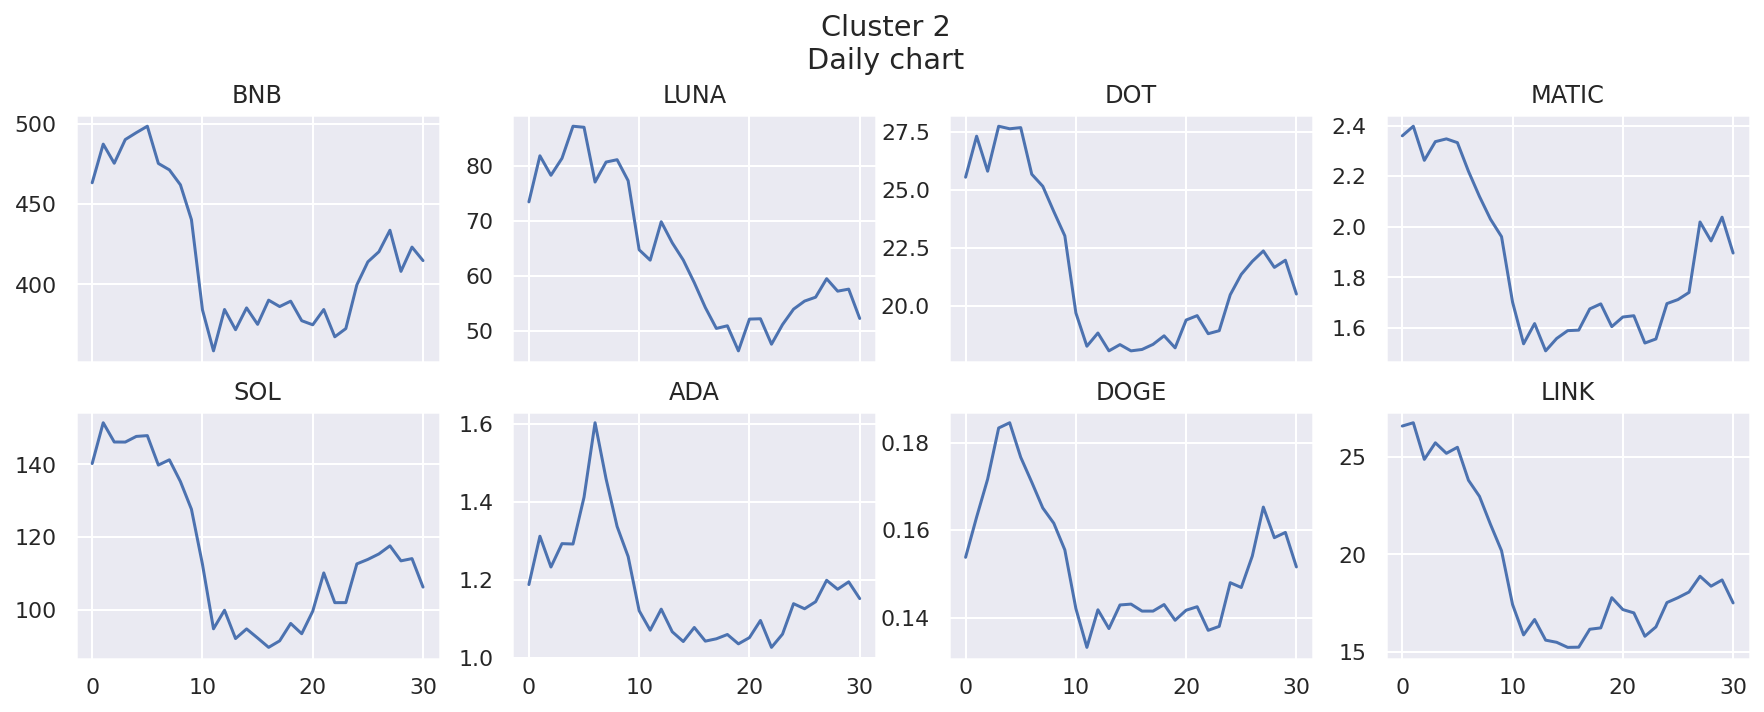

In [23]:
clustering_study(data_day, metric="euclidean", title = "Daily chart")

##### KNeighbours, DTW

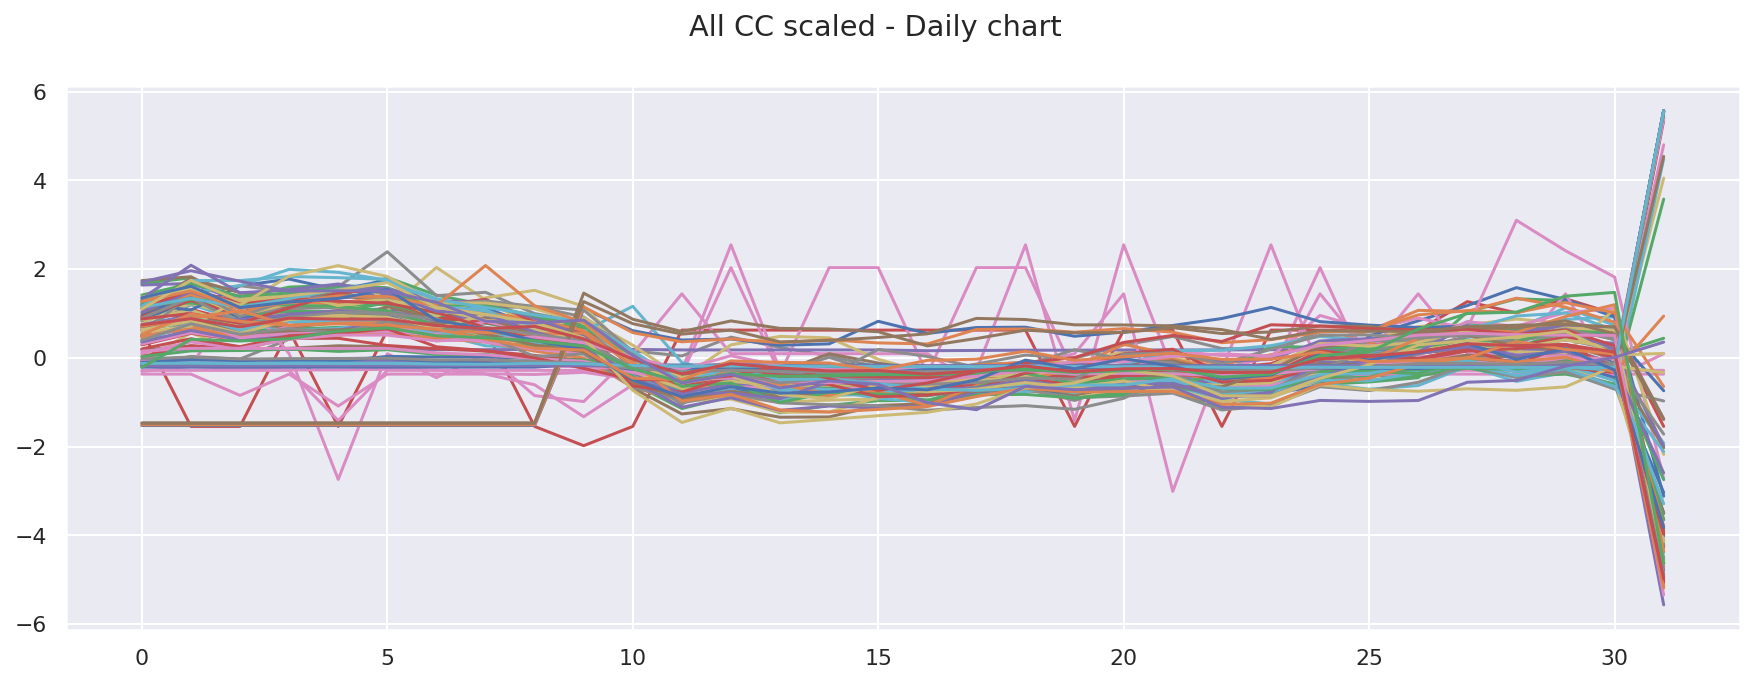

  0%|          | 0/8 [00:00<?, ?it/s]

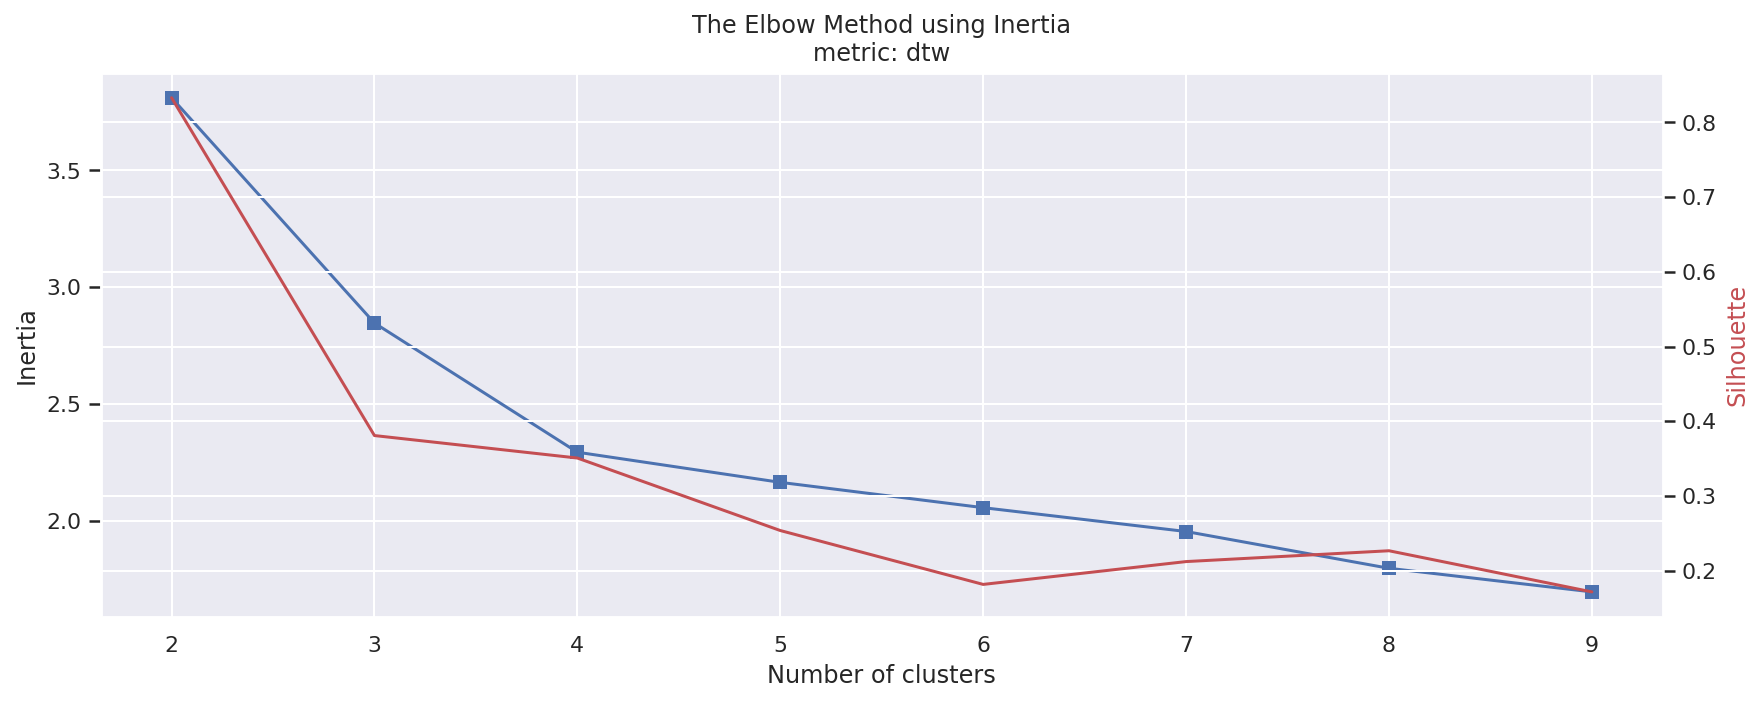

Optimal number of clusters - 4


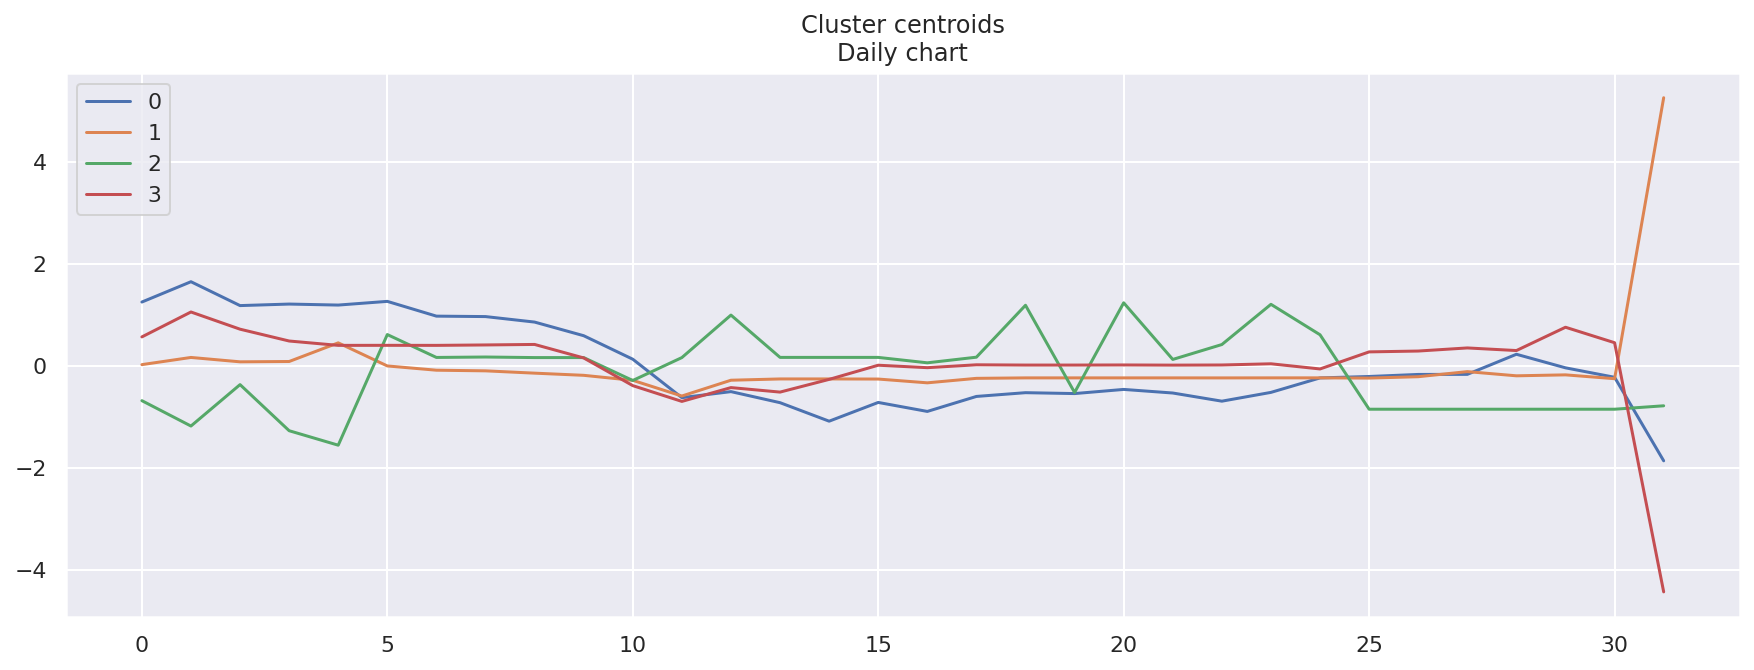

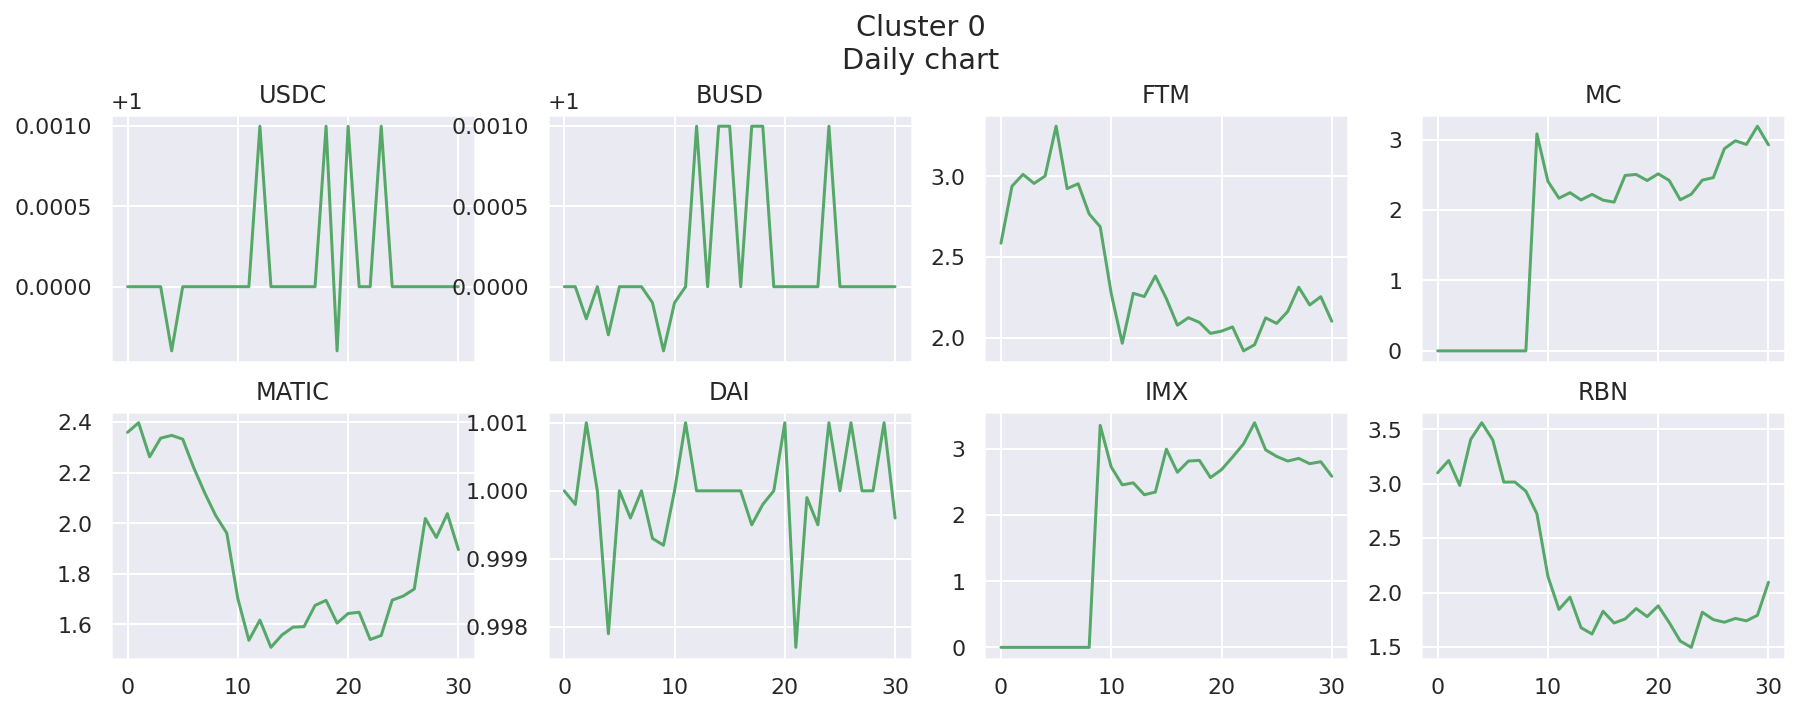

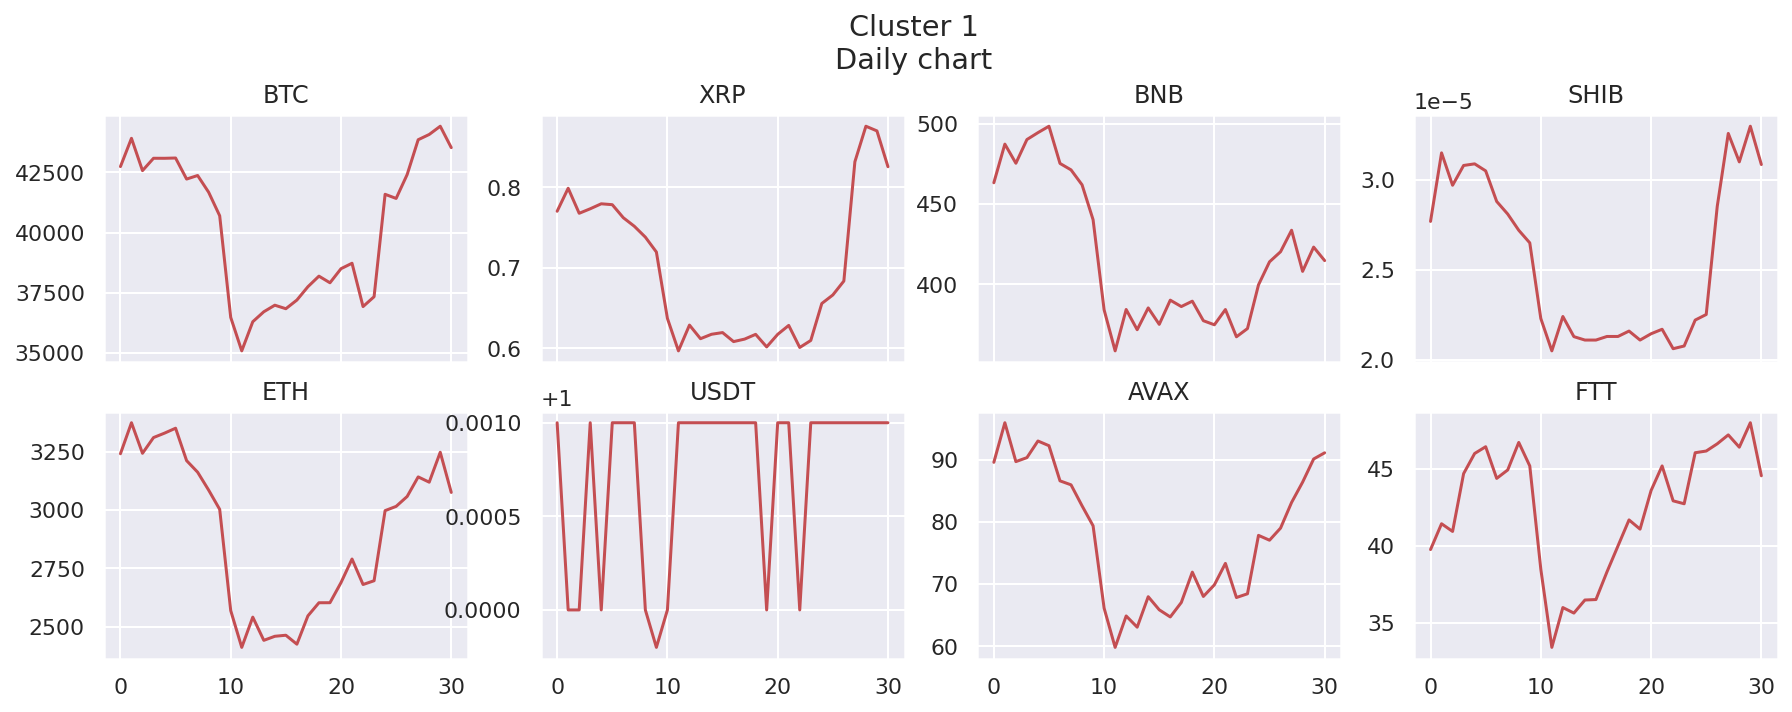

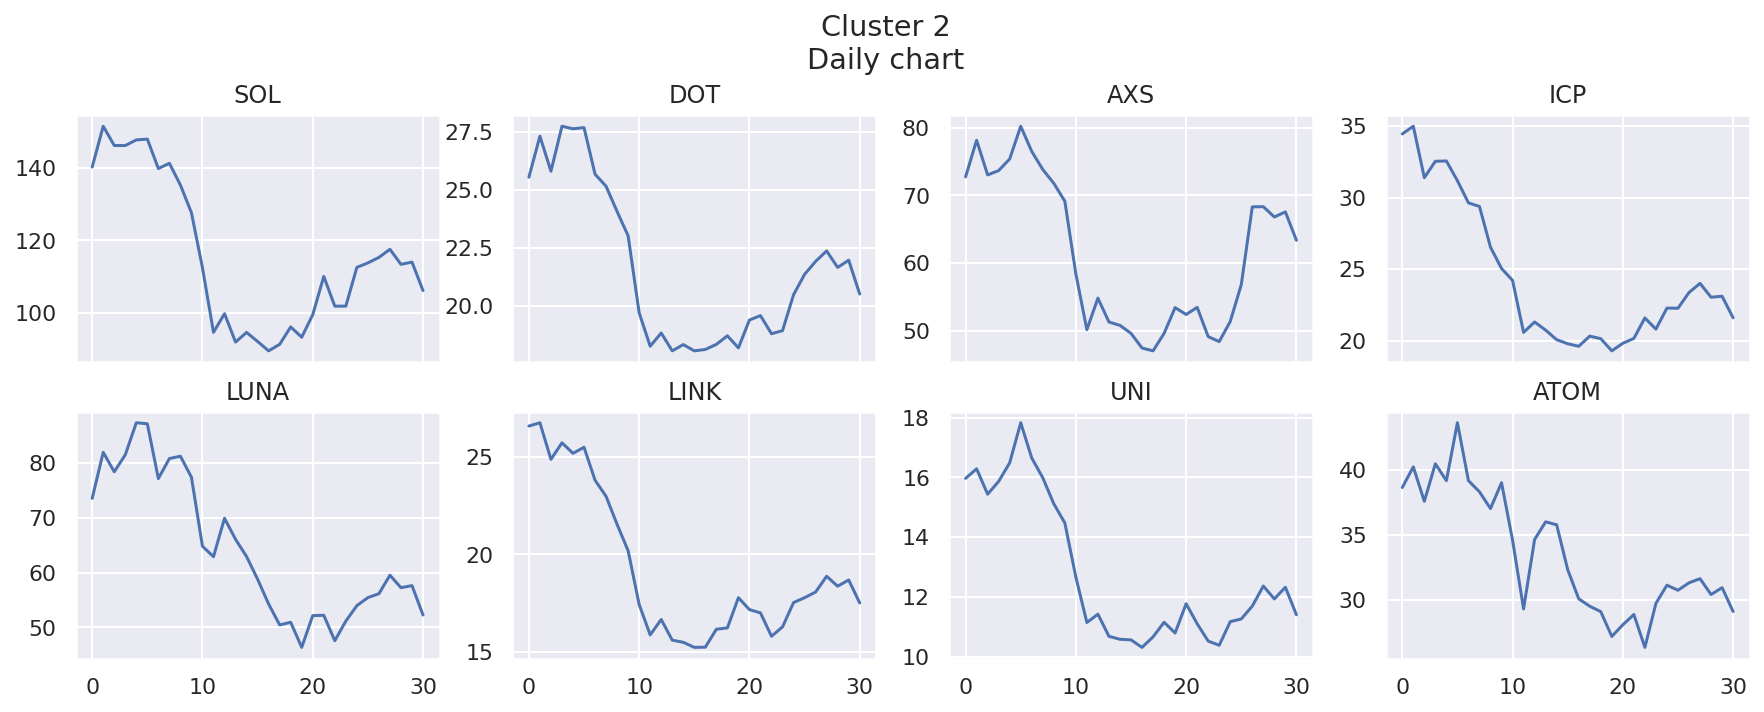

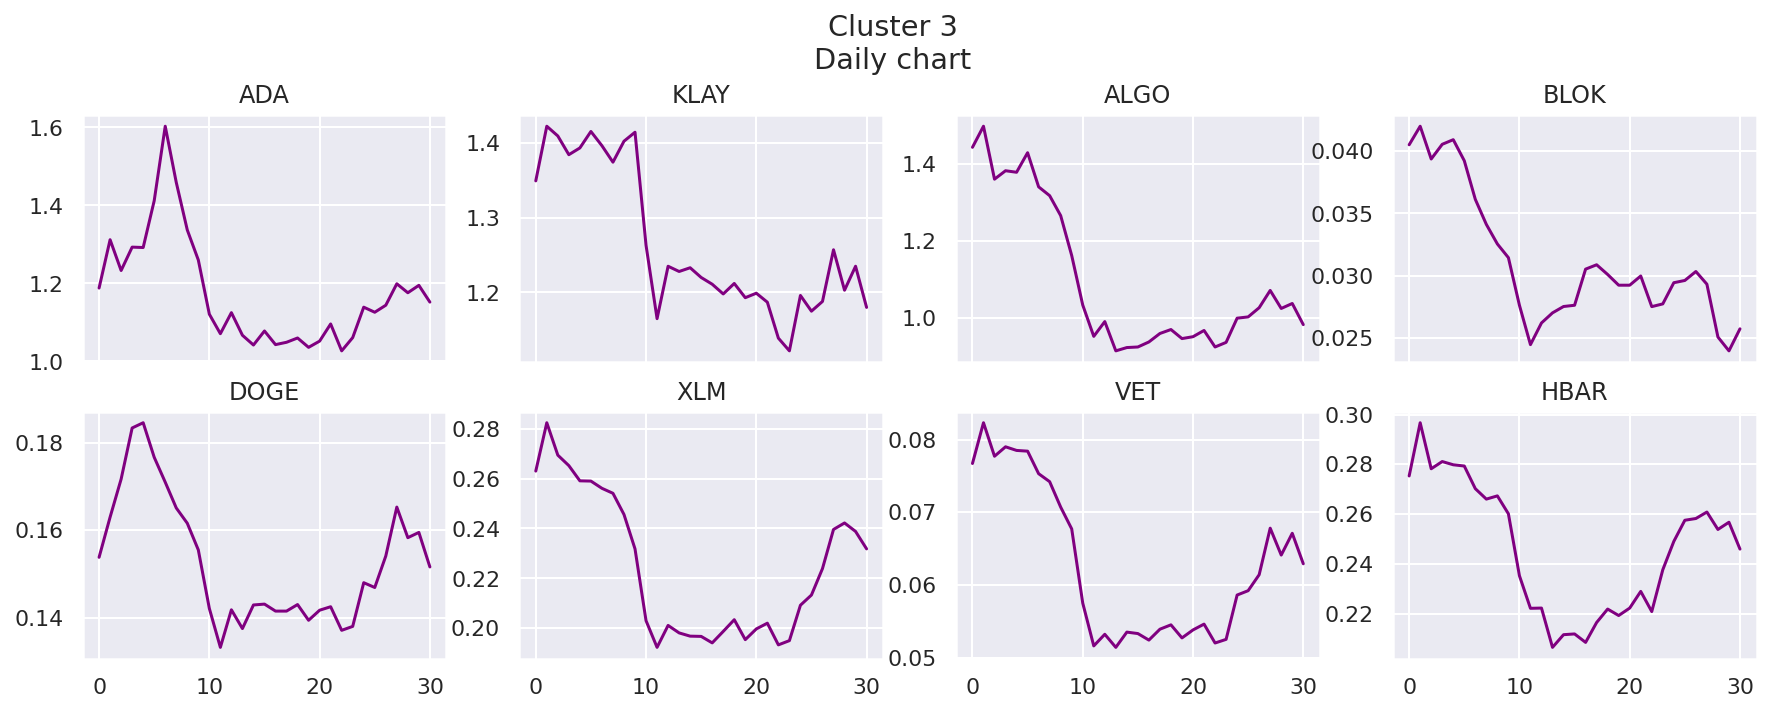

In [24]:
clustering_study(data_day, metric="dtw", title = "Daily chart")

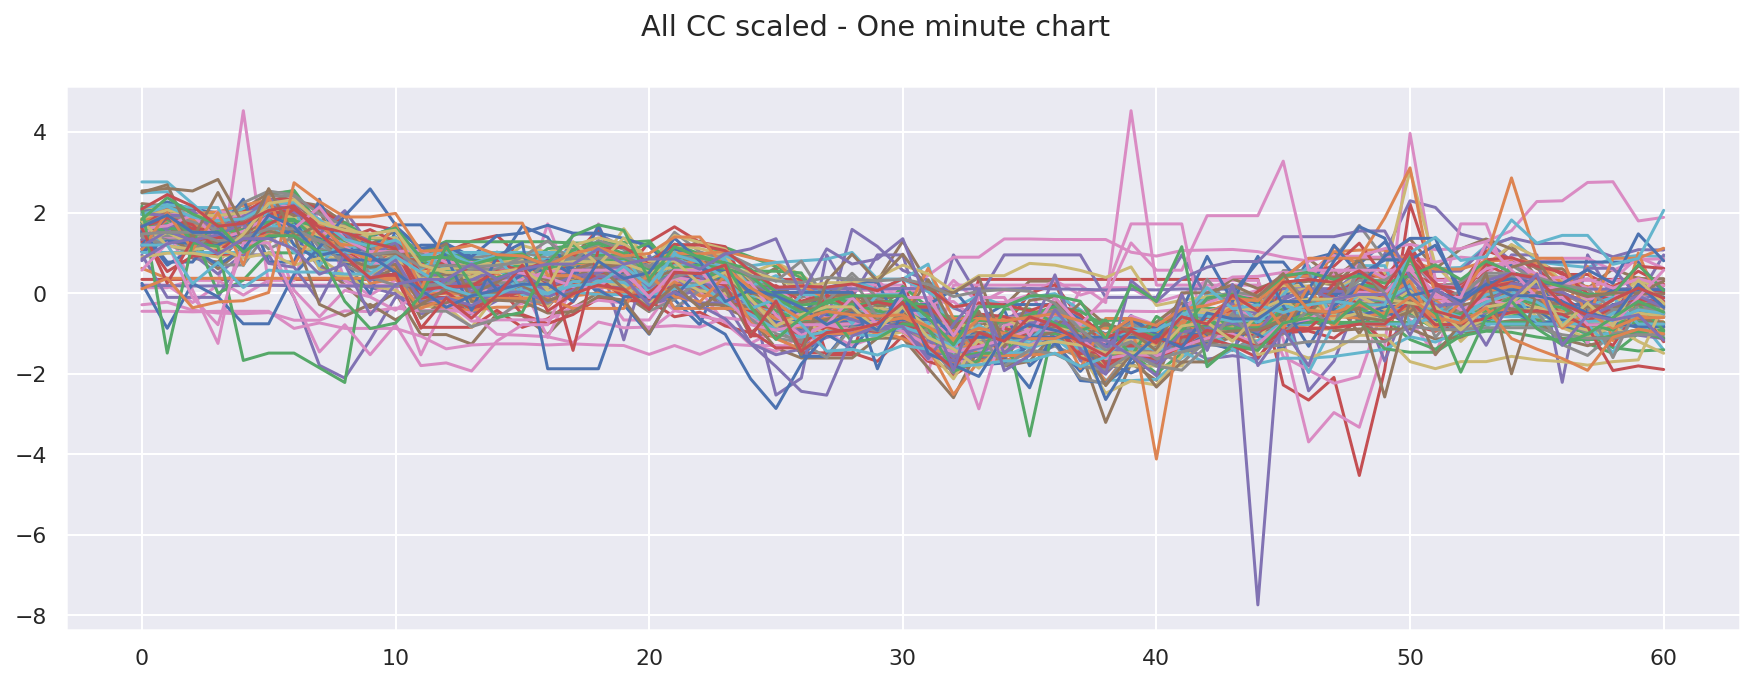

  0%|          | 0/8 [00:00<?, ?it/s]

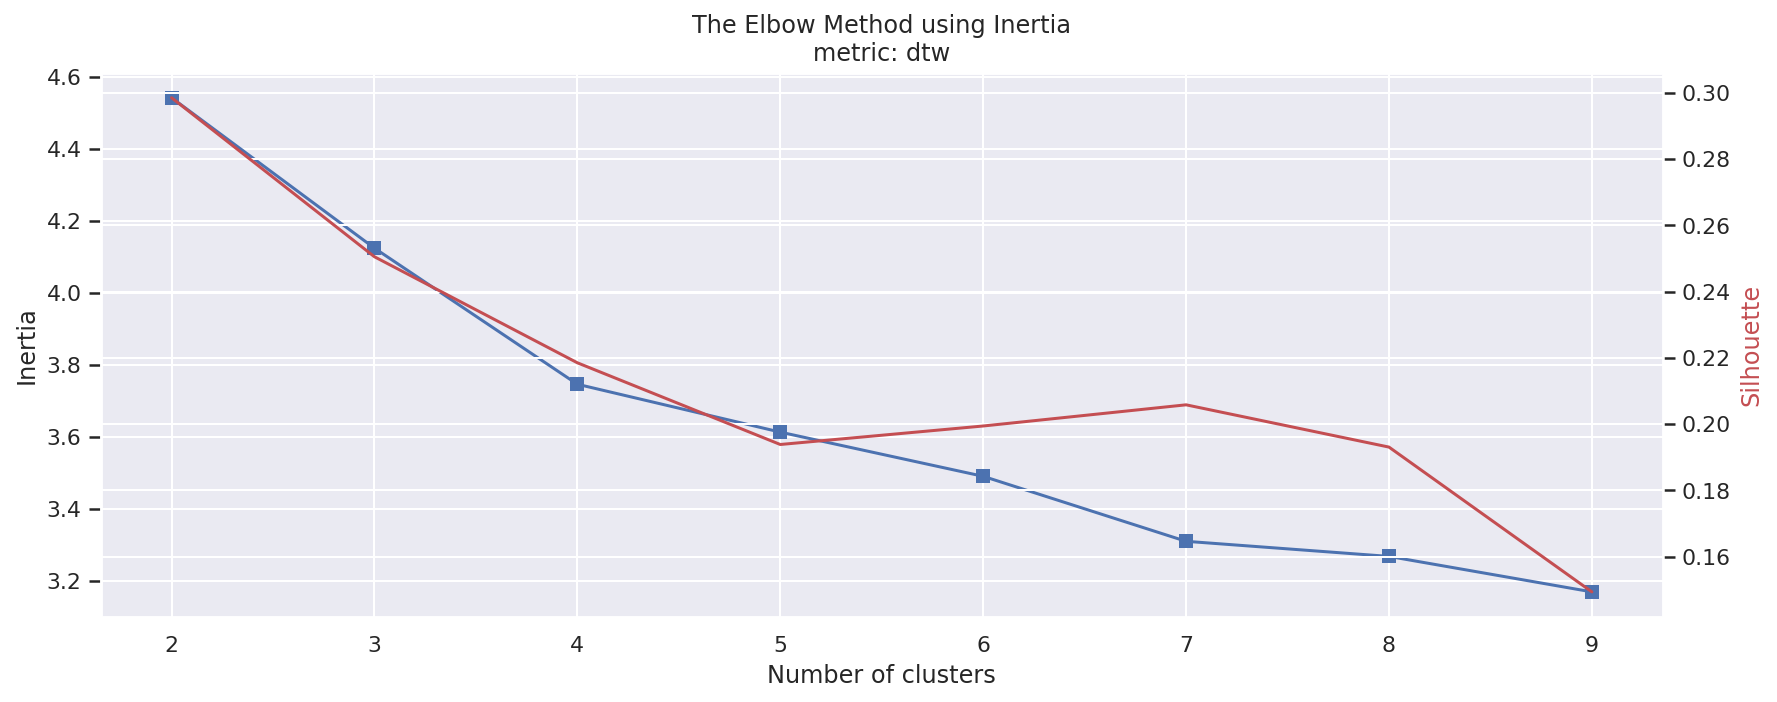

Optimal number of clusters - 4


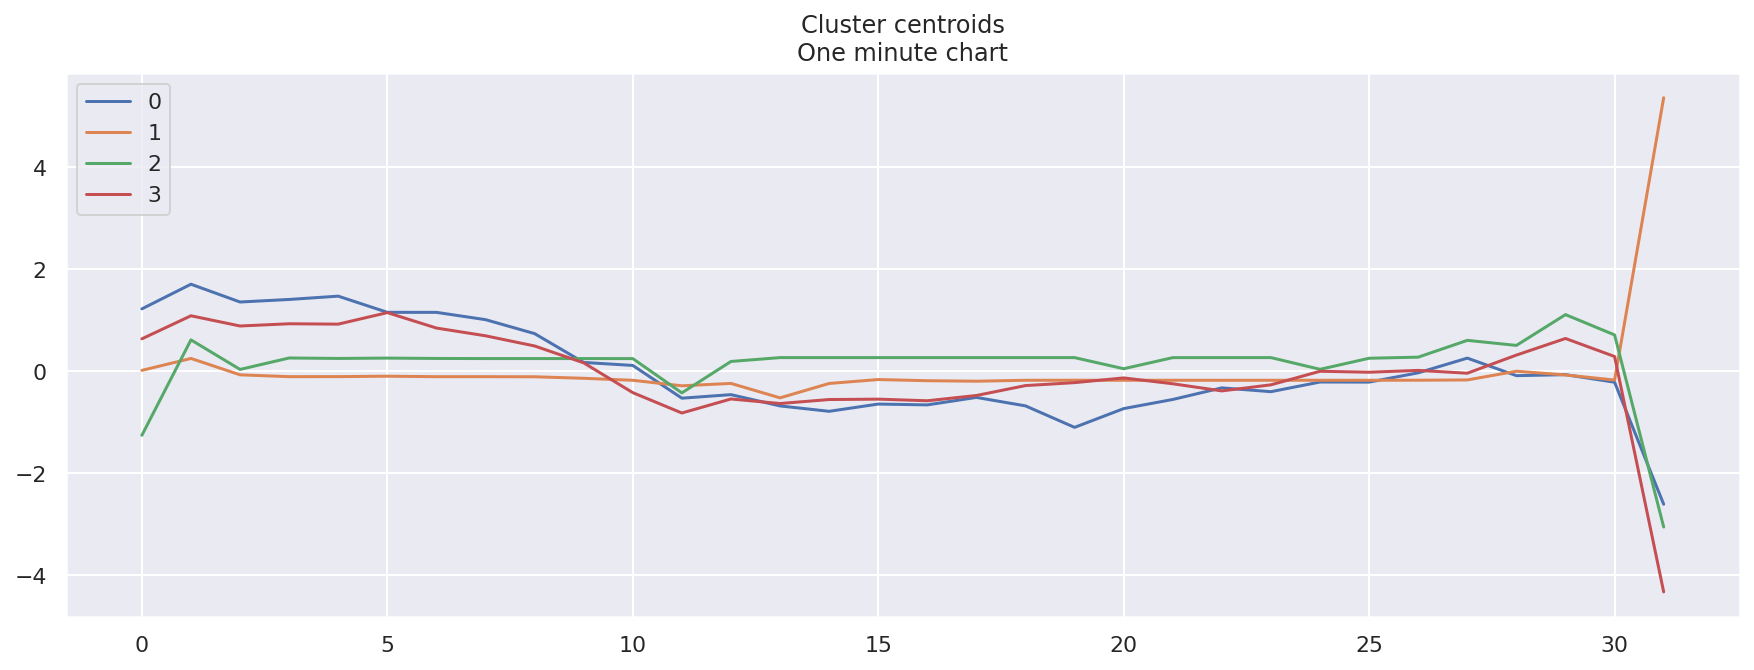

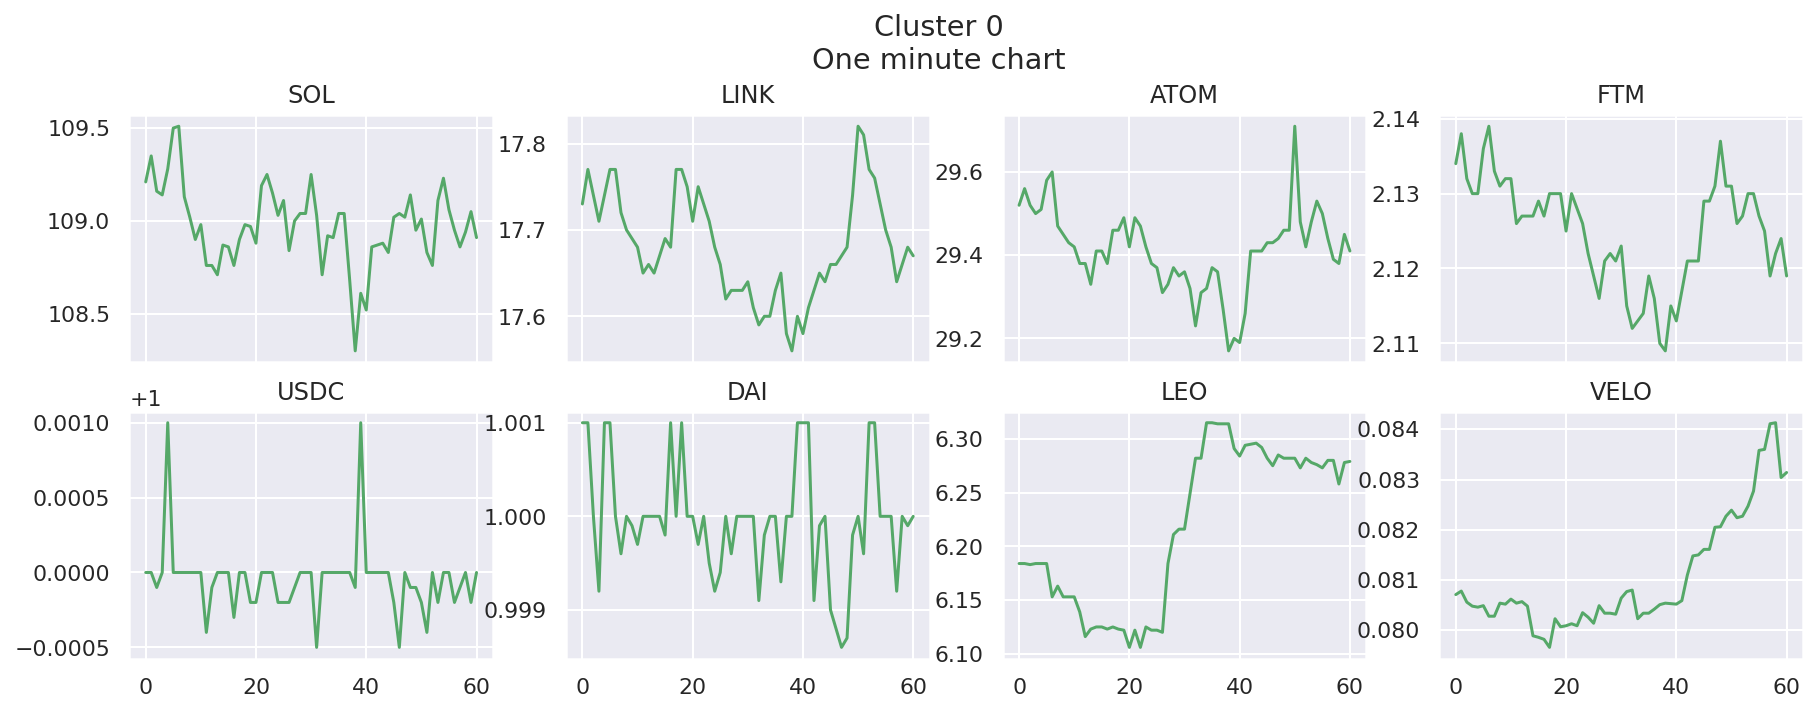

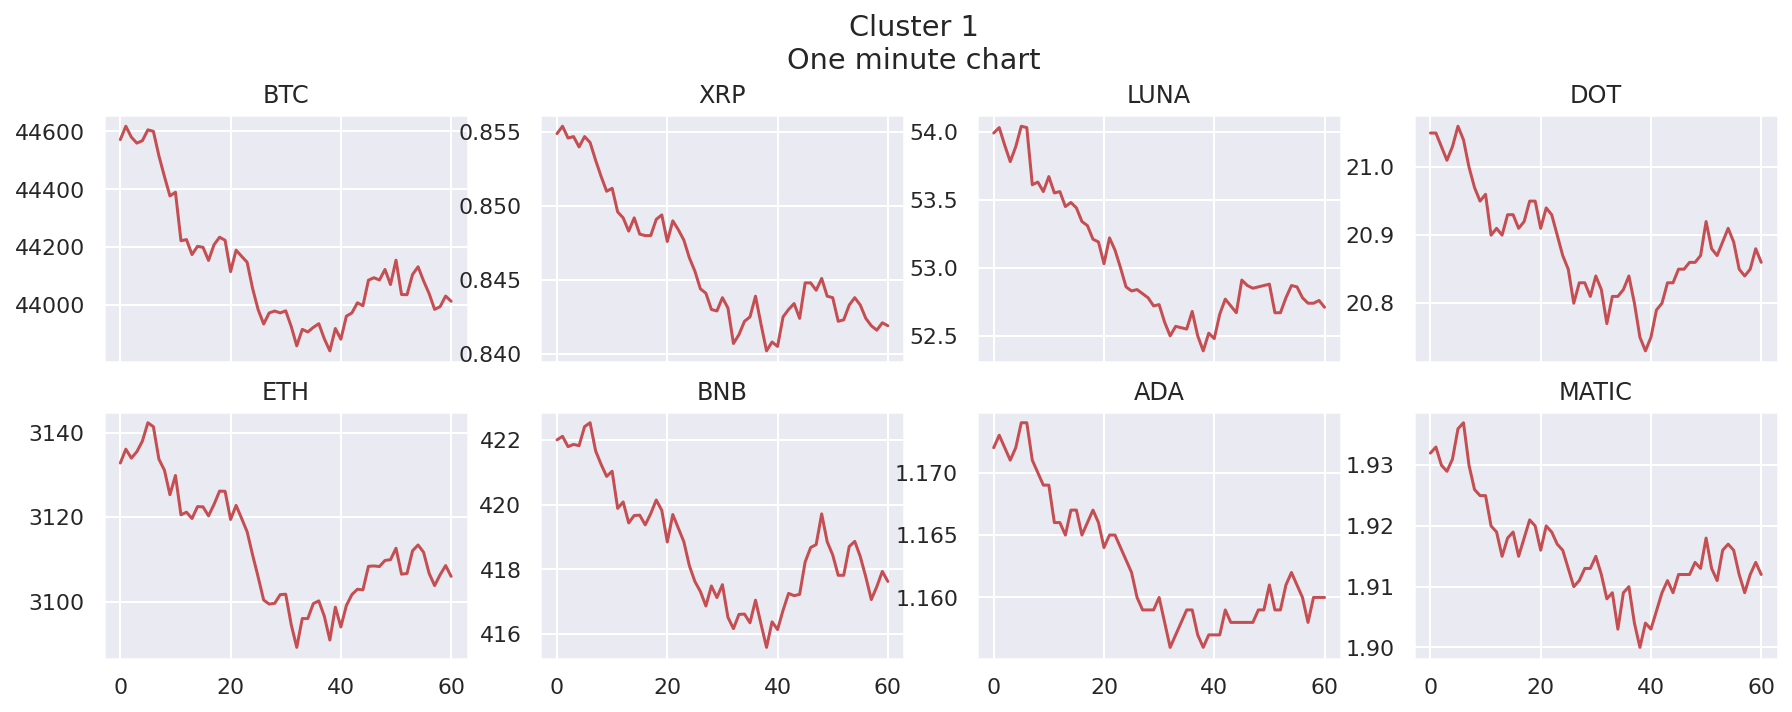

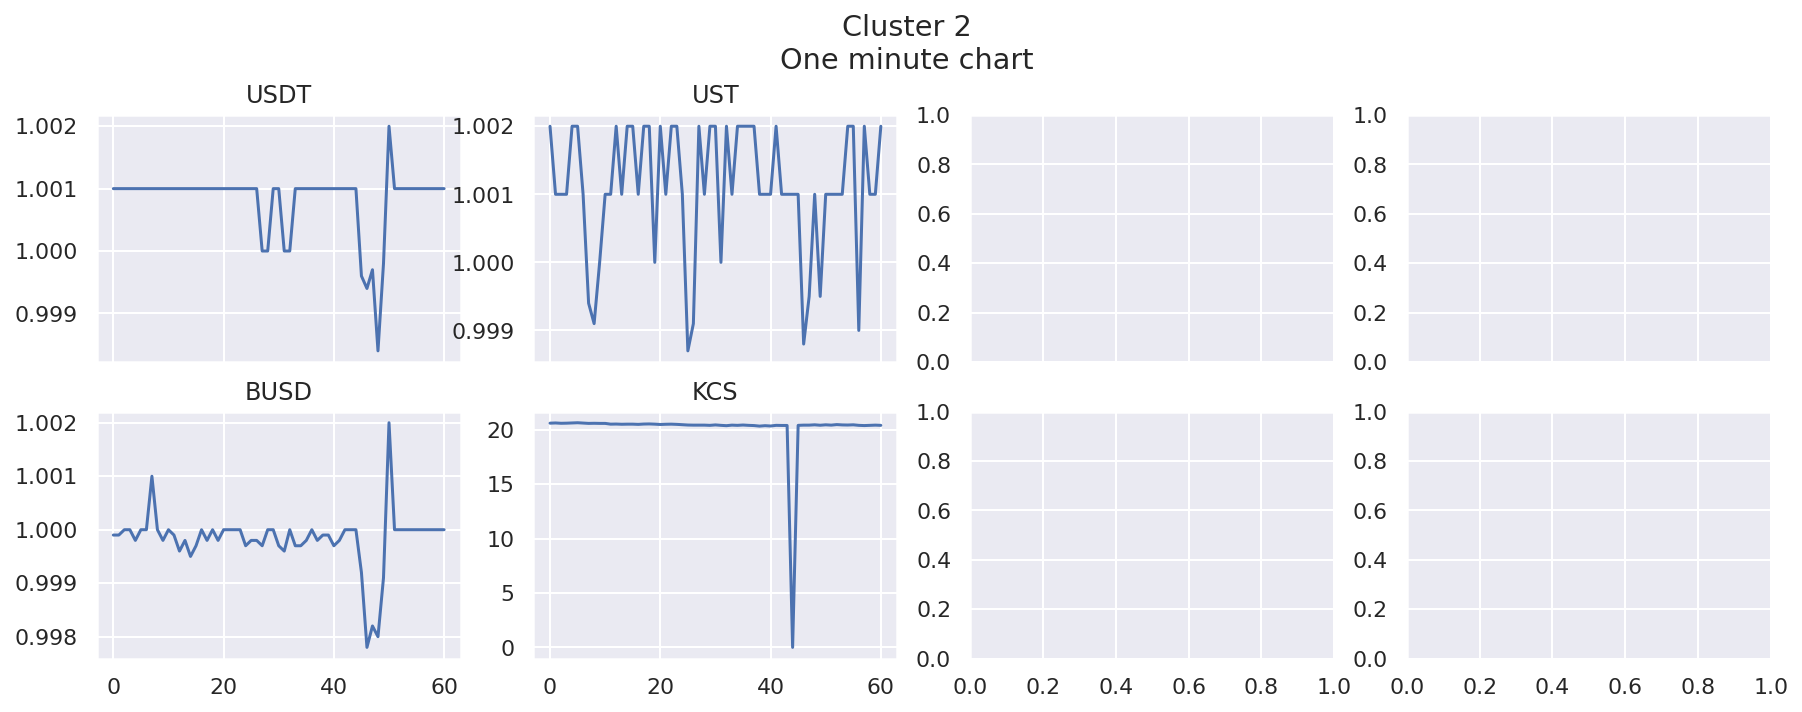

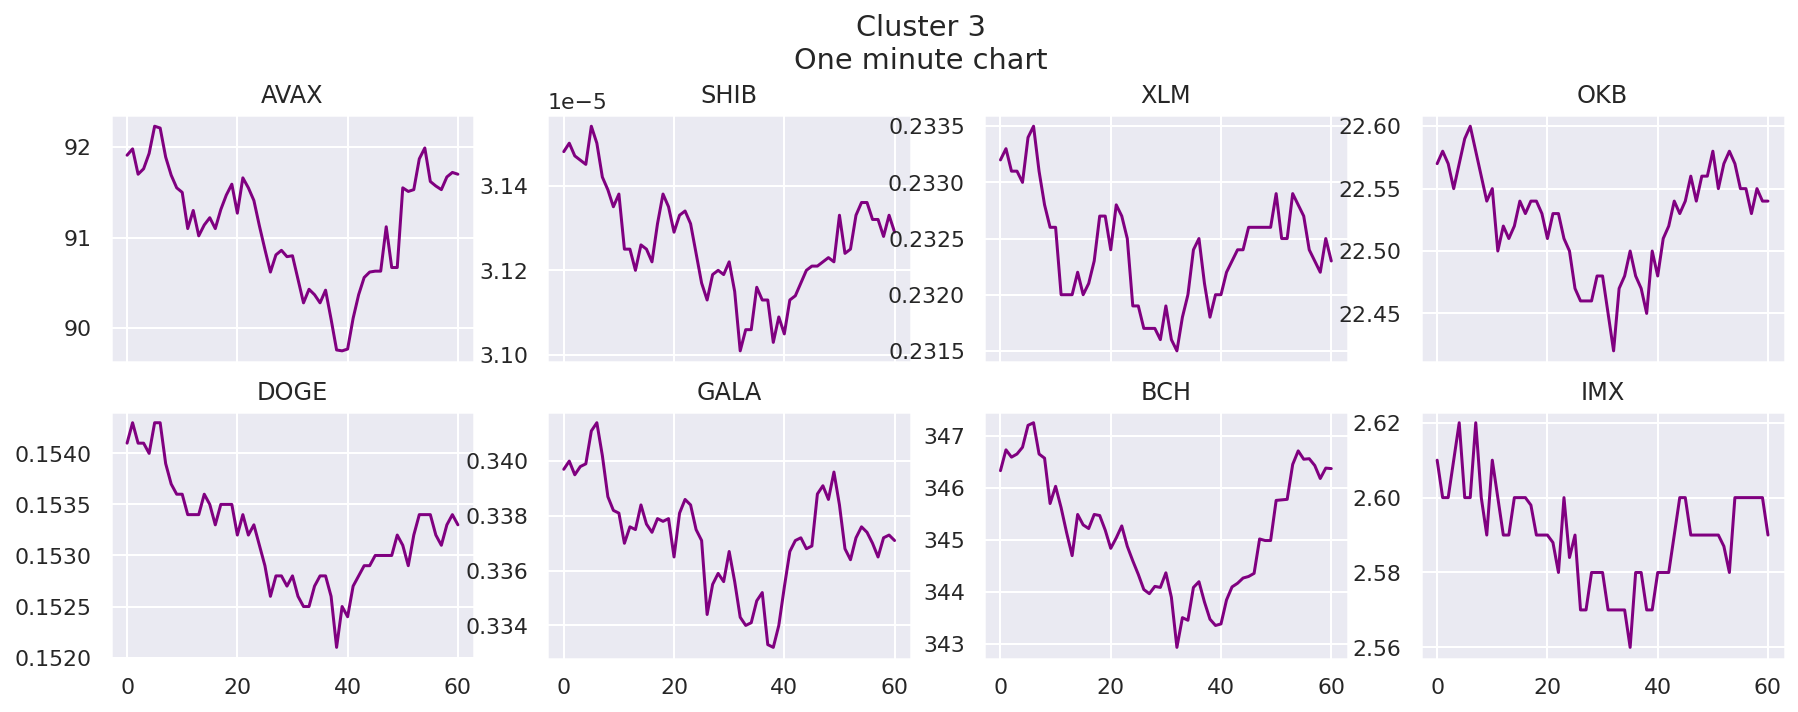

In [25]:
clustering_study(data_minute, metric="dtw", title = "One minute chart")

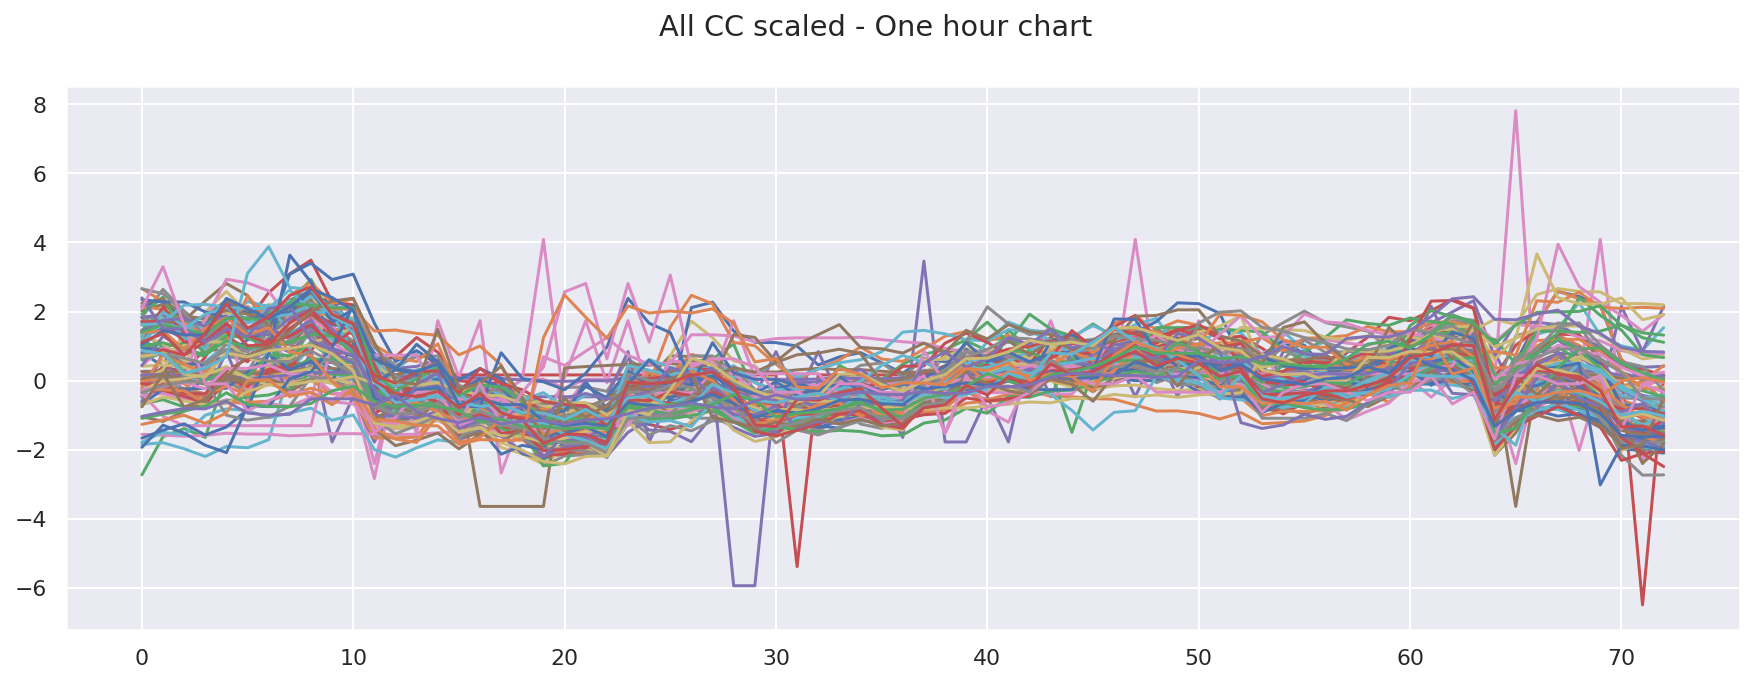

  0%|          | 0/8 [00:00<?, ?it/s]

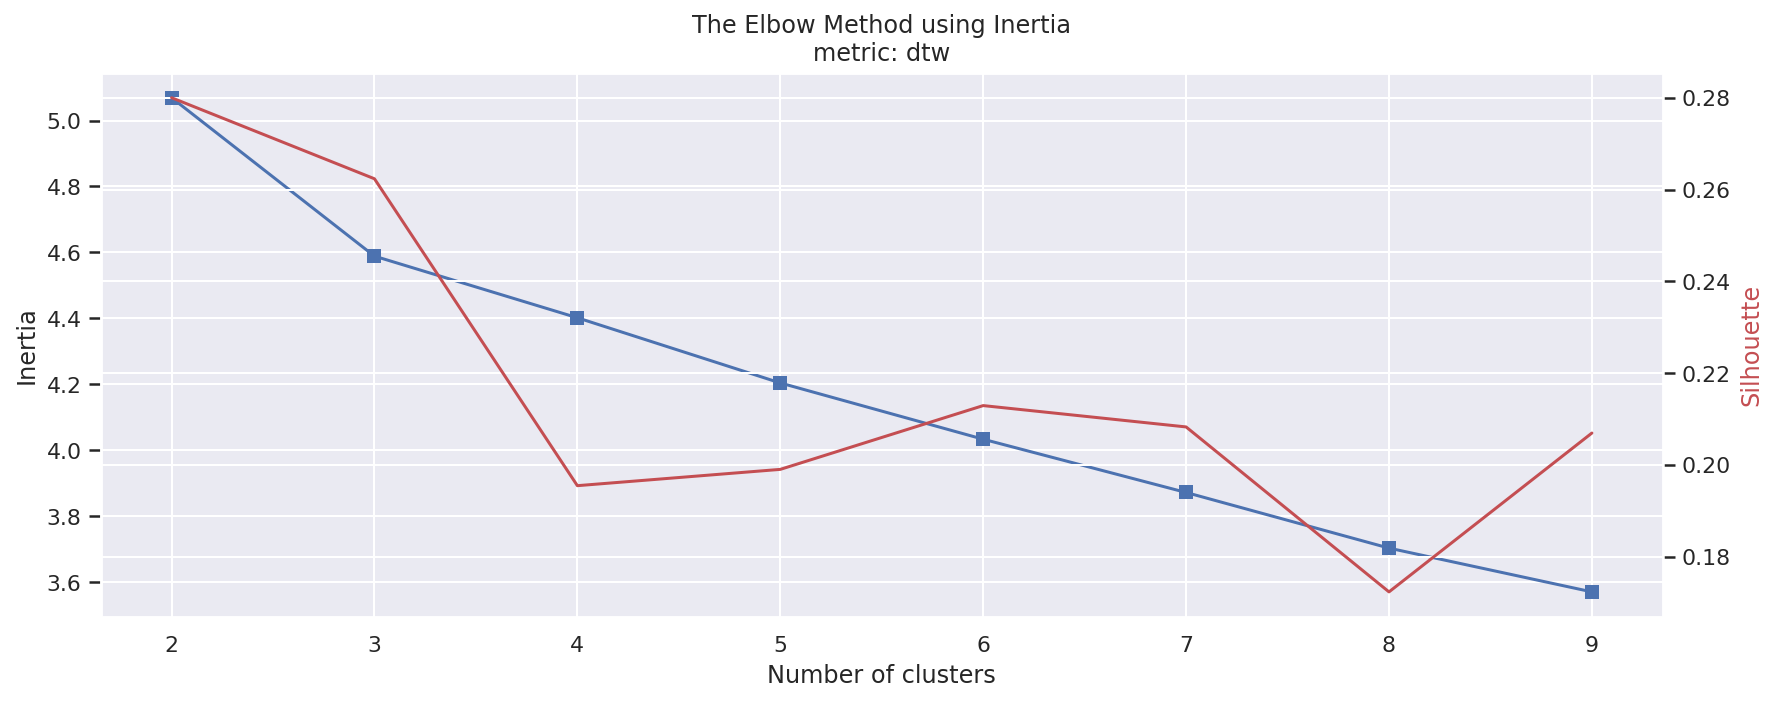

Optimal number of clusters - None


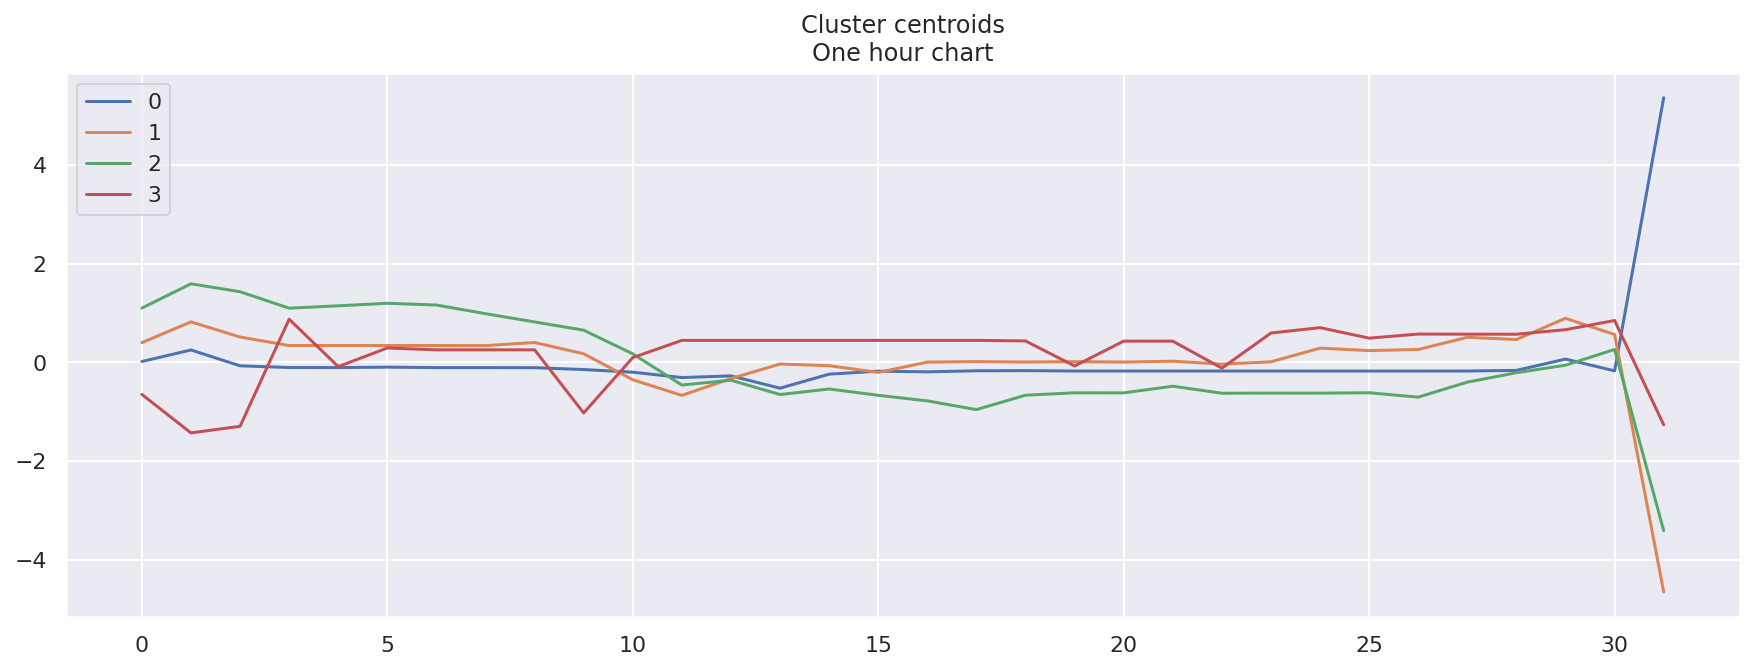

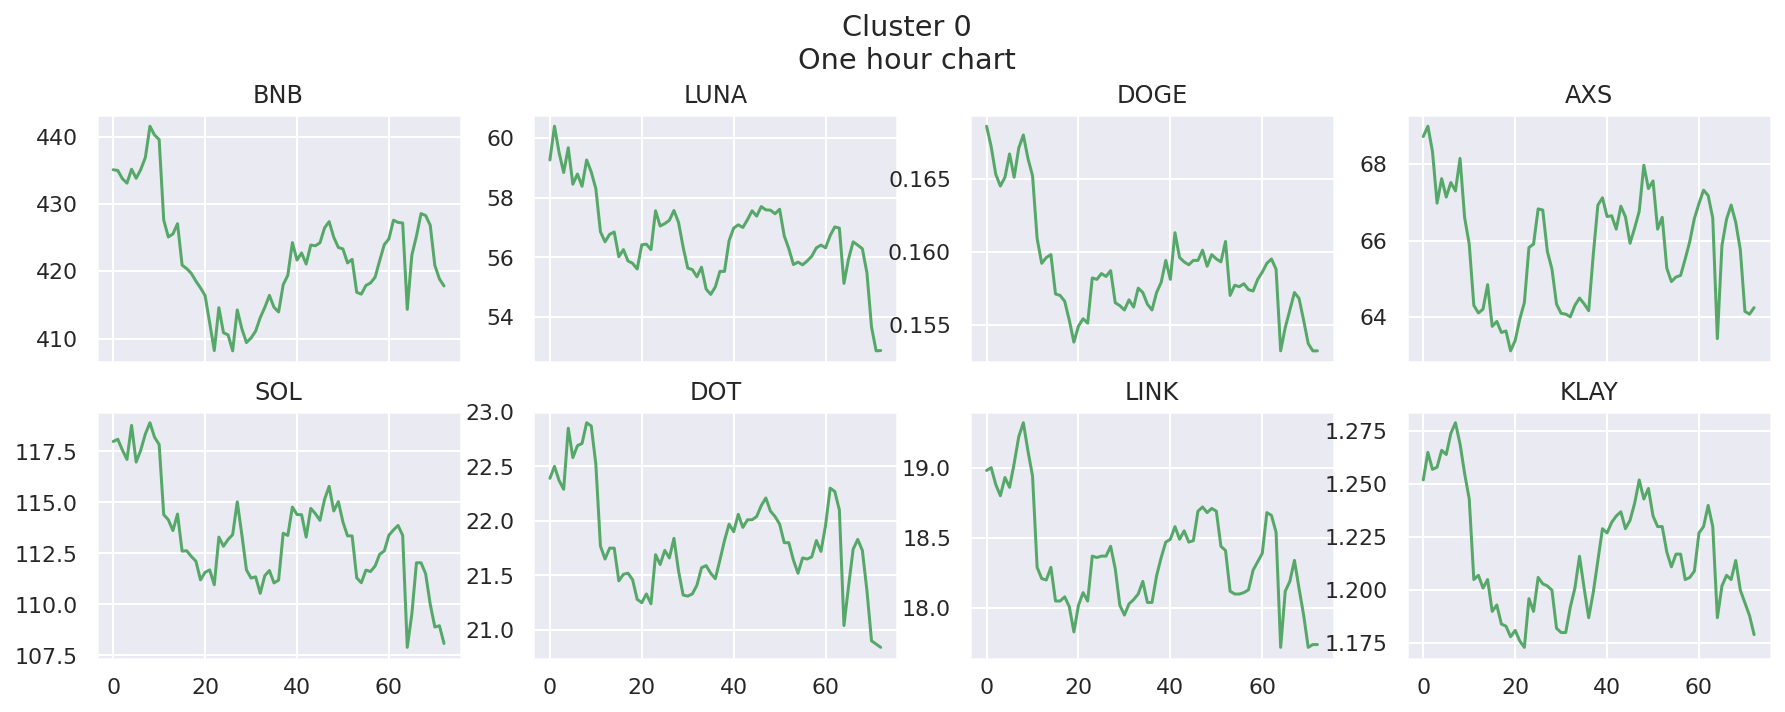

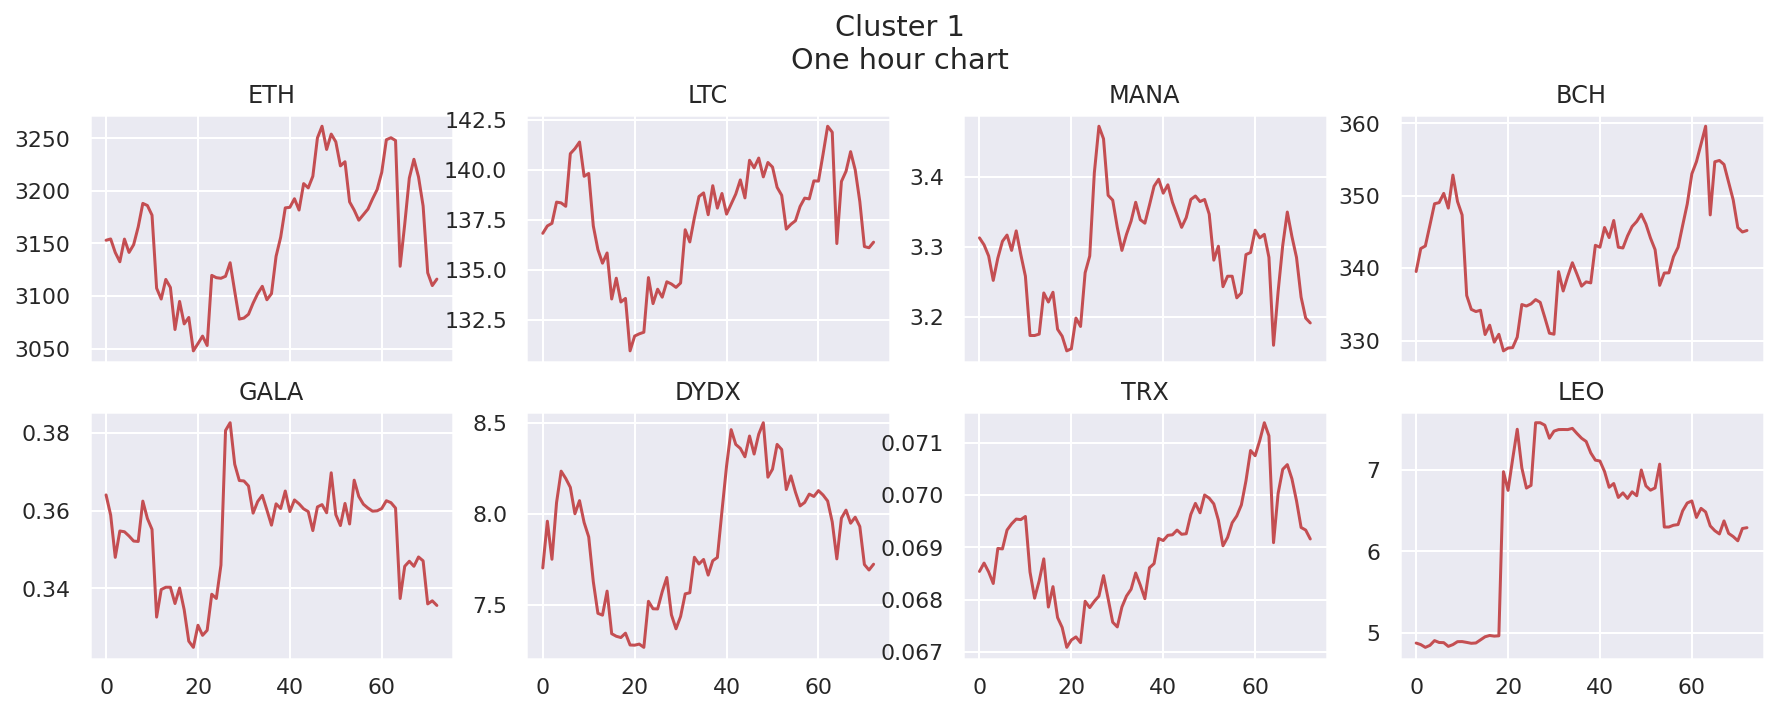

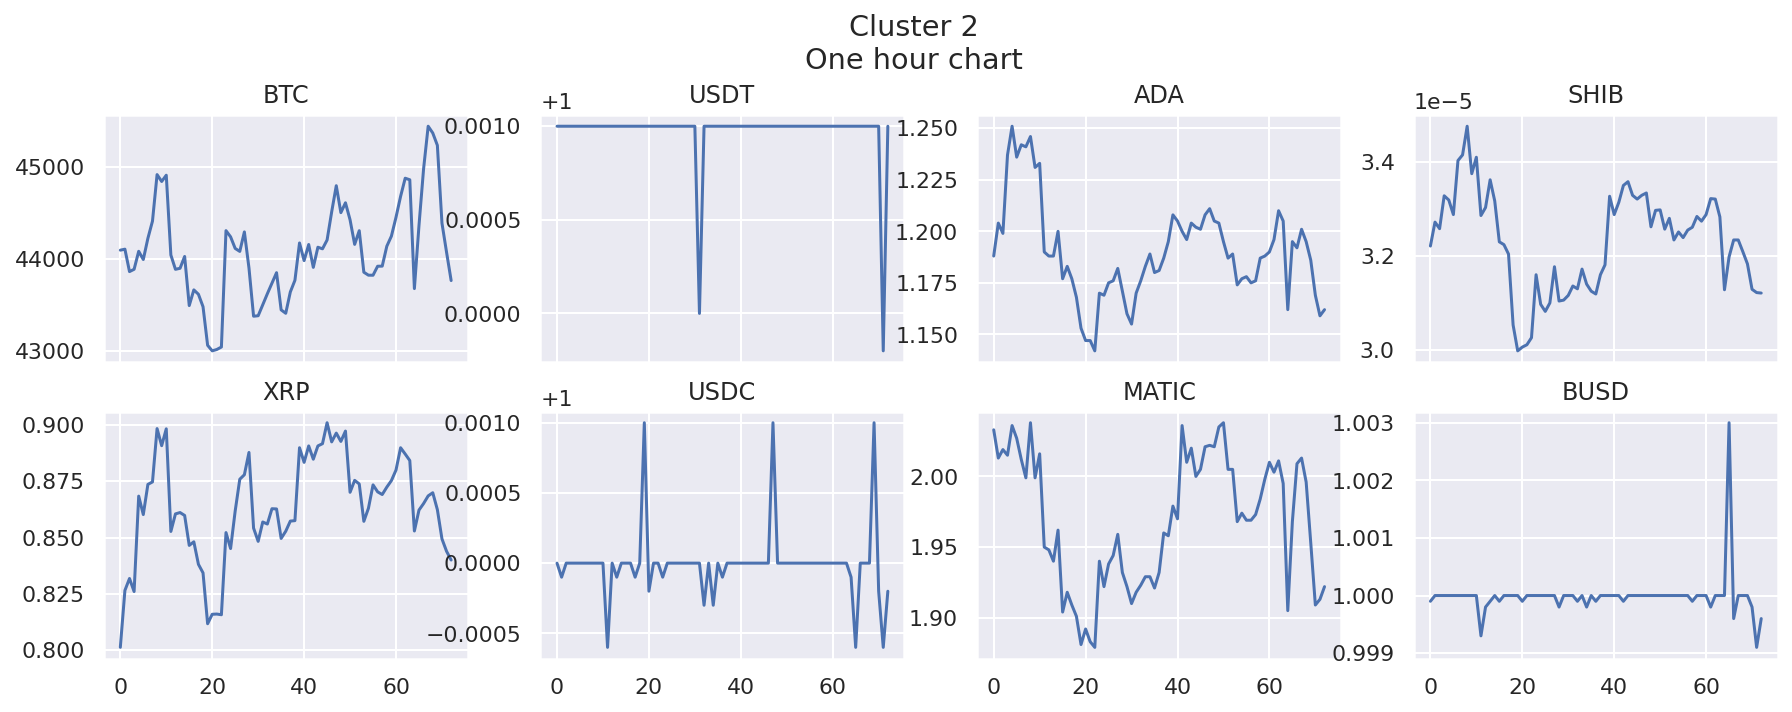

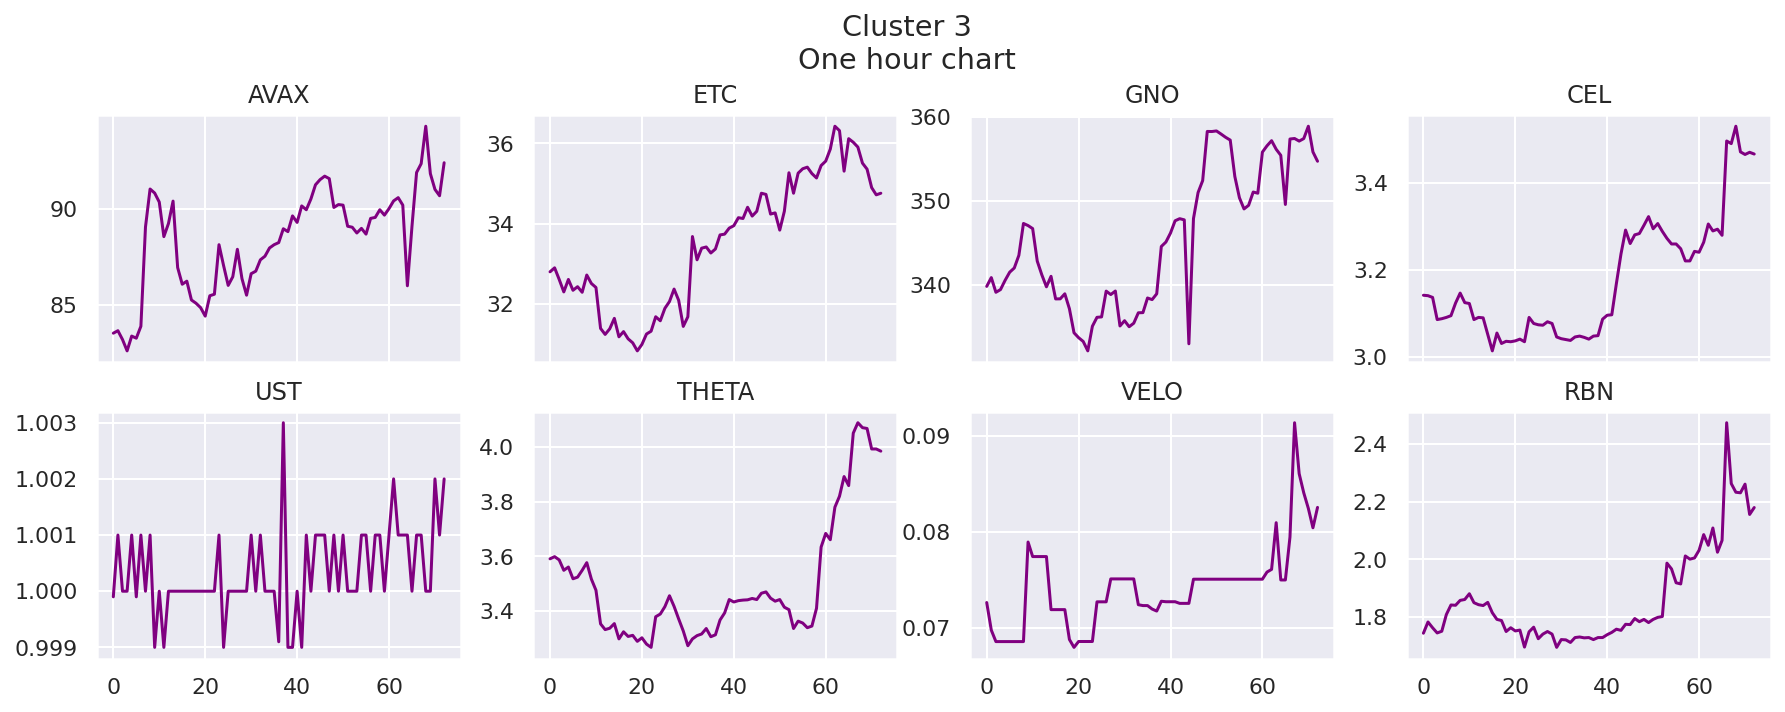

In [26]:
clustering_study(data_hour, metric="dtw", title = "One hour chart")

#### Check Google Drive data status

In [27]:
url = "https://drive.google.com/uc?export=download&id=1XCOhxPfRDp6SxMyPwPO1nse3MI2vOFvP"
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.107 Safari/537.36' }
requests.head(url, headers=headers).status_code

302

### Take part of data

In [28]:
rand_part = 0.2 # for testing of computationally expensive parts
partial = 0 # for rapid tests set to 1 and possibly change rand_part ratio above

# Randomly select rand_part of rows
part = sorted(random.choices(range(df.shape[0]), k=int(df.shape[0]*rand_part)))
if partial == 0:
    X, y = df.iloc[:,:-1], df.iloc[:,-1]
else:
    X, y = df.iloc[part,:-1], df.iloc[part,-1]
# df.shape
X.shape, y.shape

NameError: name 'df' is not defined

### Instantiate ATOM

In [ ]:
atom = ATOMClassifier(X, y, test_size=0.25, n_jobs=n_jobs, 
                      verbose=1, warnings=False, random_state=random_state)
atom.title_fontsize = 17

### Preprocessing (minimal)

In [ ]:
atom.impute()
atom.clean(drop_min_cardinality=False)
atom.encode()
# atom.add(StandardScaler())
atom.add(RobustScaler())
# atom.gauss()

### Baseline model - LogisticRegression  
### OOB models - RandomForest and LightGBM

To put comptitors on the level ground, we will apply Bayesian H/P optimization to OOB models

In [ ]:
atom.branch = "baseline_and_oob"
# Fit the models to the data with Bayesian optimisation
atom.run(
    models=models,
    metric=metric,
    n_calls=n_calls,
    n_initial_points=n_initial_points,
    n_bootstrap=5
)

In [ ]:
atom.branch.status()

In [ ]:
atom.plot_results(title="Logistic Regression, RandomForest, LightGBM", figsize=(10,5))

In [ ]:
with atom.canvas(1, 3, title="Confusion matrices of Baseline and OOB models", figsize =(15,4.5)):
    atom.lr0.plot_confusion_matrix(dataset="test", normalize=True, title=f"LR") 
    atom.rf0.plot_confusion_matrix(dataset="test", normalize=True, title=f"RF")
    atom.lgb0.plot_confusion_matrix(dataset="test", normalize=True, title=f"LightGBM")

In [ ]:
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

In [ ]:
atom.plot_bo(title="BO scores", figsize=(10,5))

In [ ]:
with atom.canvas(1, 2, title="LightGBM evaluation curves\non train and test"):    
    atom.lgb0.plot_evals(dataset="train", figsize=(5,5))
    atom.lgb0.plot_evals(dataset="test", figsize=(5,5))

### Feature engineering for AutoML

#### Run DFS

In [ ]:
atom.verbose = 2
atom.branch = "auto_from_master"
atom.feature_generation("dfs", 
                        n_features=n_features_dfs, 
                        operators=["add", "sub", "mul"], #, "div"
                        n_jobs = n_jobs,
                        verbose=0,
                        random_state=random_state)

#### Make post-DFS feature selection

In [ ]:
atom.feature_selection(
    strategy="RFECV",
    solver="RF",
    n_features=n_features_rfecv,
    scoring="F1_weighted",
    max_correlation=0.98,
    random_state=random_state,
    n_jobs=n_jobs
)

In [ ]:
atom.plot_rfecv(title="Score per number of features - DFS", figsize=(10,5))

Dataset with new DFS features

In [ ]:
atom.X.head()

In [ ]:
atom.X.shape

In [ ]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

In [ ]:
print(f"New dataset has {atom.X.shape[1]} features")

### Create AutoML model with DFS

In [ ]:
# atom.branch = "auto_ml"

In [ ]:
atom.verbose=2
atom.automl(
            max_time_mins=360,
            template="Transformer-Transformer-Classifier",
            early_stop = 2,
            cv=5,
            n_jobs=n_jobs,
            random_state = random_state
)

### Final model

#### TPOT configuration

In [ ]:
atom.tpot

In [ ]:
atom.tpot.get_params()

#### Best Pipeline

In [ ]:
atom.winner

#### Resulting pipeline

In [ ]:
atom.tpot.fitted_pipeline_

####  Export pipeline to sklearn format

In [ ]:
pl = atom.export_pipeline(model="rf")
print(pl)

In [ ]:
atom.models

In [ ]:
atom.status()

#### AutoML pipeline scores

In [ ]:
score = atom.rf.score(X, y)
print(f"\nScore on all data: {score:.4f}")

In [ ]:
atom.rf.plot_confusion_matrix(dataset="test", normalize=True, title=f"Confusion matrix for AutoML model", figsize=(8,5)) 

### Compare models results

In [ ]:
atom.plot_results(title="ATOM autoML vs Baseline and OOB", figsize=(10,5))

In [ ]:
nice_metric_table(atom.results, metric=metric).style.highlight_max(props='color:orange', axis=0)

#### Make predictions - see pipeline in action

In [ ]:
atom.rf.predict(X)

### Conclusion

It took several hours and many TPOT generations to obtain an AutoML model that beats the best H/P-tuned OOB model (LGB in this case) in 3 out of 4 metrics. The winner takes it all, but TPOT is not a miracle, model generation takes a lot of time.